## Diabetes and Demographic Indicators in the United States

This project seeks to analyze various demographic indicators and lifestyle behaviors as they relate to the incidence of diabetes in the United States. Diabetes research and data analysis is crucial as it addresses a global health crisis affecting millions of people; our project will focus on different outcomes in the U.S. Diabetes is a chronic condition that can lead to serious complications such as heart disease, kidney failure, blindness, and amputations. Understanding the disease's mechanisms, risk factors, and effective treatments along with lifestyle improvements is vital for improving patient outcomes, reducing healthcare costs, and preventing the onset of diabetes in at-risk populations. Research in this field also supports the development of new therapies, technologies, and public health strategies that can significantly improve quality of life and reduce the burden of diabetes on individuals and society.

The project will aim to answer the following questions:
- Are the following general demographic indicators correlated with diabetes?
	- Income
	- Education
	- Age
- How are these demographic indicators correlated with the following lifestyle choices?
	- Fruit and vegetable consumption
    - Physical activity
	- Recent cholesterol check
	- BMI
	- Heavy alcohol consumption
- How is each lifestyle choice above correlated with diabetes outcome?


In [2]:
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import csv, convert to a dataframe. List the columns so we know how to clean it up
diabetes_csv = pd.read_csv("source_data/diabetes_indicators.csv")
diabetes_df = pd.DataFrame(diabetes_csv)
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [4]:
# Define colors
colors = ['#CACACA','#78909C','#616161']

# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


## William - Overall Trends; Fruit and Vegetable Consuption

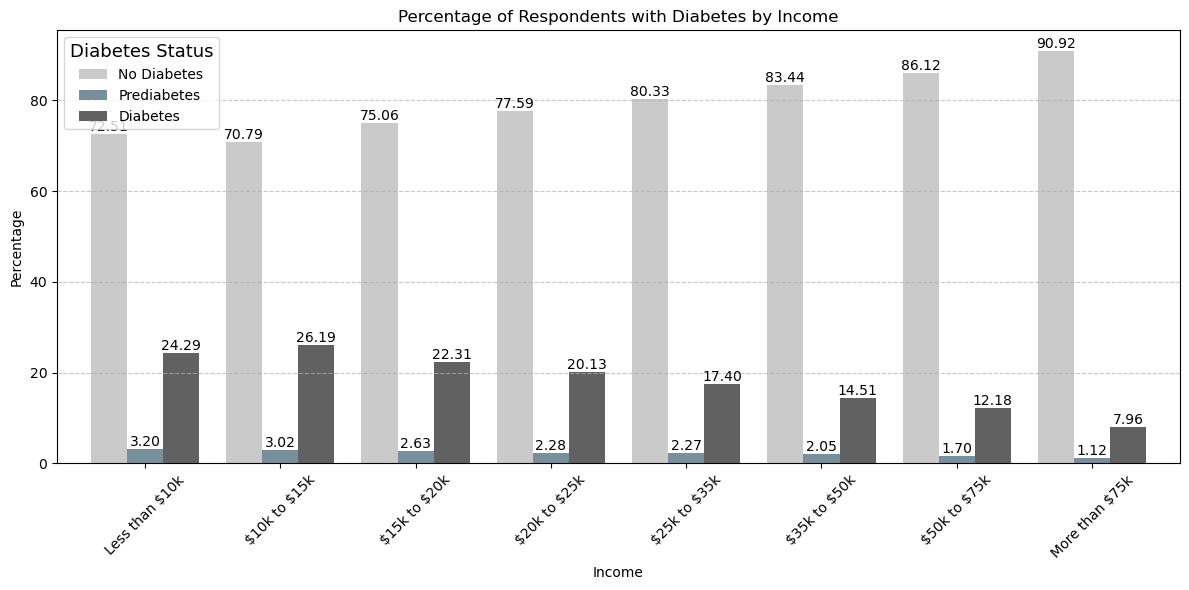

In [6]:
# Group by income and diabetes, count the number of responses in each row
dia_income = df_trimmed.groupby(["Income", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_group_sum = dia_income.groupby('Income')['count'].transform('sum')

# Calculate the proportions
dia_income['proportion'] = (dia_income['count'] / income_group_sum) * 100

# Pivot the table
income_pivot_df = dia_income.pivot(index='Income', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
income_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }
income_pivot_df.index = income_pivot_df.index.map(index_mapping)

# Plot the table
ax = income_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Income')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_pivot_df.index)), labels=income_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/income_vs_diabetes.png")
plt.show()

In [7]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(income_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
income_highlow = income_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(income_highlow)

# Output the results
print(f"Between highest and lowest incomes:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all income categories:
Chi-squared statistic: 20.955290636300568
p-value: 0.10278372465862062
Degrees of freedom: 14
Expected frequencies:
[[79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]
 [79.59434271  2.28396611 18.12169118]]
The p-value of the chi-squared test is 0.1028. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
Between highest and lowest incomes:
Chi-squared statistic: 11.345133956369702
p-value: 0.0034390260310833915
Degrees of freedom: 2
Expected frequencies:
[[81.71575368  2.15951884 16.12472748]
 [81.71575368  2.15951884 16.12472748]]
The p-value of the chi-squared test is 0.0034. As this value is less than 0.05, we reject the null hypothesis. The samples are therefor

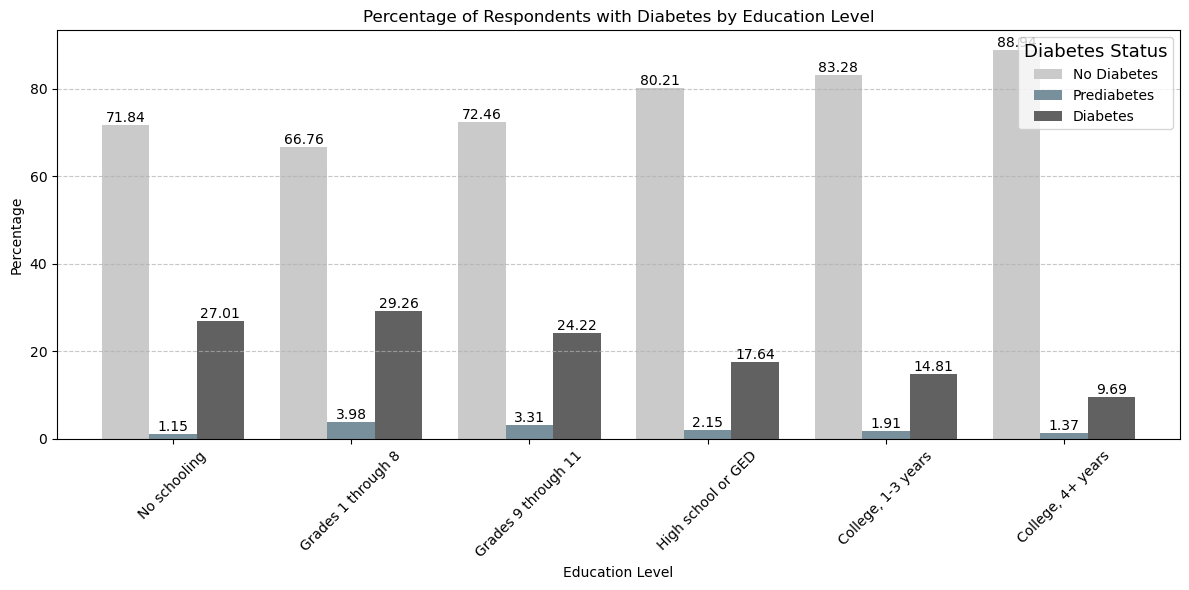

In [8]:
# Group by education and diabetes, count the number of responses in each row
dia_edu = df_trimmed.groupby(["Education", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each education group
education_group_sum = dia_edu.groupby('Education')['count'].transform('sum')

# Calculate the proportions
dia_edu['proportion'] = (dia_edu['count'] / education_group_sum) * 100

# Pivot the table
edu_pivot_df = dia_edu.pivot(index='Education', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
edu_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }
edu_pivot_df.index = edu_pivot_df.index.map(index_mapping)

# Plot the table
ax = edu_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edu_pivot_df.index)), labels=edu_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/education_vs_diabetes.png")
plt.show()

In [9]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(edu_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
edu_highlow = edu_pivot_df.loc[["No schooling", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(edu_highlow)

# Output the results
print(f"Between highest and lowest education:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all education categories:
Chi-squared statistic: 21.35383135918522
p-value: 0.01875700976065913
Degrees of freedom: 10
Expected frequencies:
[[77.24908751  2.31221449 20.43869801]
 [77.24908751  2.31221449 20.43869801]
 [77.24908751  2.31221449 20.43869801]
 [77.24908751  2.31221449 20.43869801]
 [77.24908751  2.31221449 20.43869801]
 [77.24908751  2.31221449 20.43869801]]
The p-value of the chi-squared test is 0.0188. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.
Between highest and lowest education:
Chi-squared statistic: 10.01291366913178
p-value: 0.006694581343093912
Degrees of freedom: 2
Expected frequencies:
[[80.38914191  1.2600143  18.3508438 ]
 [80.38914191  1.2600143  18.3508438 ]]
The p-value of the chi-squared test is 0.0067. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.


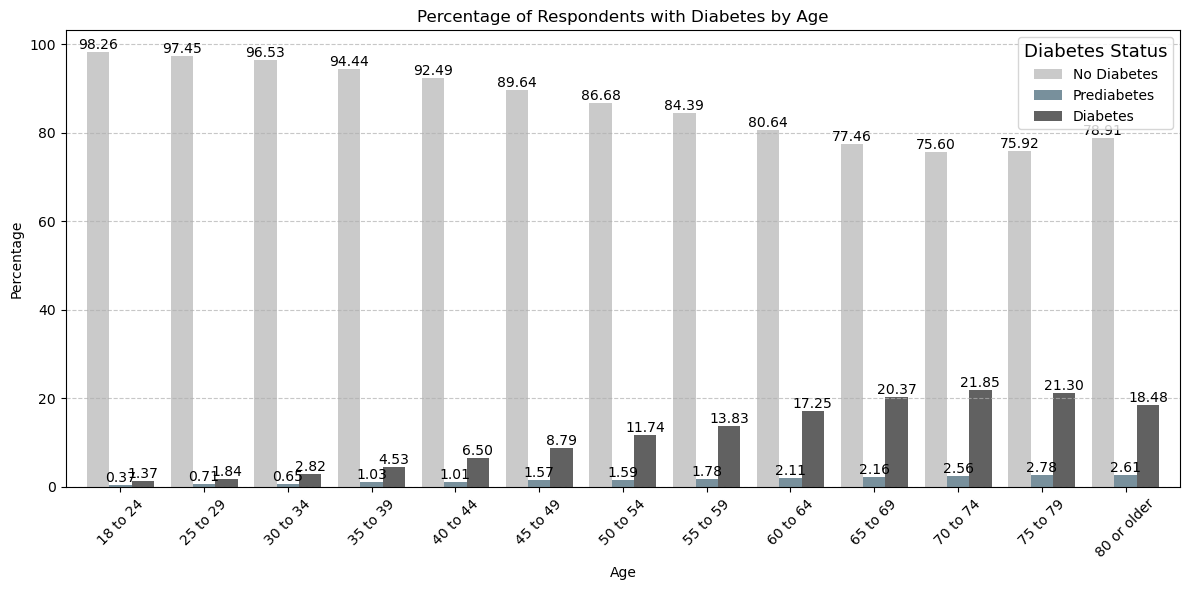

In [10]:
# Group by age and diabetes, count the number of responses in each row
dia_age = df_trimmed.groupby(["Age", "Diabetes_012"]).size().reset_index(name='count')

# Calculate the sum of responses for each age group
age_group_sum = dia_age.groupby('Age')['count'].transform('sum')

# Calculate the proportions
dia_age['proportion'] = (dia_age['count'] / age_group_sum) * 100

# Pivot the table
age_pivot_df = dia_age.pivot(index='Age', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
age_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }
age_pivot_df.index = age_pivot_df.index.map(index_mapping)

# Plot the table
ax = age_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Diabetes by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_pivot_df.index)), labels=age_pivot_df.index, rotation=45)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/age_vs_diabetes.png")
plt.show()

In [11]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(age_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
age_highlow = age_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(age_highlow)

# Output the results
print(f"Between highest and lowest age groups:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all age categories:
Chi-squared statistic: 77.16008772901847
p-value: 1.7131815735390552e-07
Degrees of freedom: 24
Expected frequencies:
[[86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]
 [86.80037313  1.61059058 11.58903629]]
The p-value of the chi-squared test is 0.0. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.
Between highest and lowest age groups:
Chi-squared statistic: 18.554184910797428
p-value: 9.354270804725102e-05
Degrees of freedom: 2
Expected frequencies:
[[88.58616629  1.4887086   9.925125

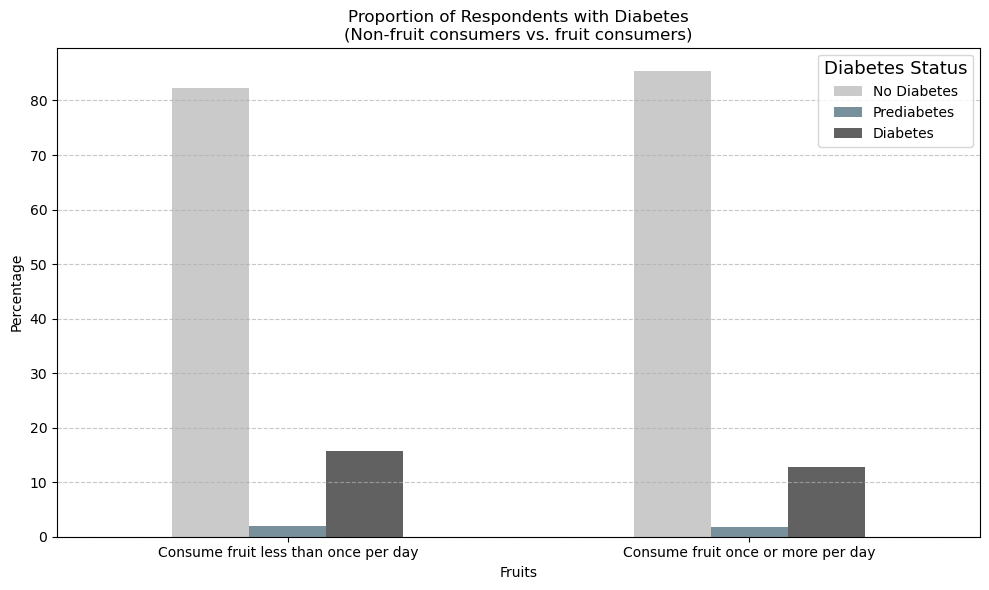

In [12]:
# Group by fruit consumption and diabetes status, count the number of participants for each category
dia_fruits = df_trimmed.groupby(["Fruits", "Diabetes_012"]).size().reset_index(name='count')

# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
nofruits = dia_fruits[dia_fruits["Fruits"] == 0].copy()
yesfruits = dia_fruits[dia_fruits["Fruits"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
nofruits_sum = nofruits["count"].sum()
nofruits["proportion"] = (nofruits["count"] / nofruits_sum) * 100

yesfruits_sum = yesfruits["count"].sum()
yesfruits["proportion"] = (yesfruits["count"] / yesfruits_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
fruitstack = pd.concat([nofruits, yesfruits], ignore_index=False)

# Set up pivot table to reorganize fruitstack df
fruit_pivot_df = fruitstack.pivot(index='Fruits', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
fruit_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume fruit less than once per day', 1.0: 'Consume fruit once or more per day'}
fruit_pivot_df.index = fruit_pivot_df.index.map(index_mapping)

# Plot the table
fruit_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-fruit consumers vs. fruit consumers)')
plt.xlabel('Fruits')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(fruit_pivot_df.index)), labels=fruit_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Images/fruit_vs_diabetes.png")
plt.show()

In [13]:
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(fruit_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

Chi-squared statistic: 0.3775524619686453
p-value: 0.8279717603927735
Degrees of freedom: 2
Expected frequencies:
[[83.81371394  1.85934759 14.32693847]
 [83.81371394  1.85934759 14.32693847]]
The p-value of the chi-squared test is 0.828. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.


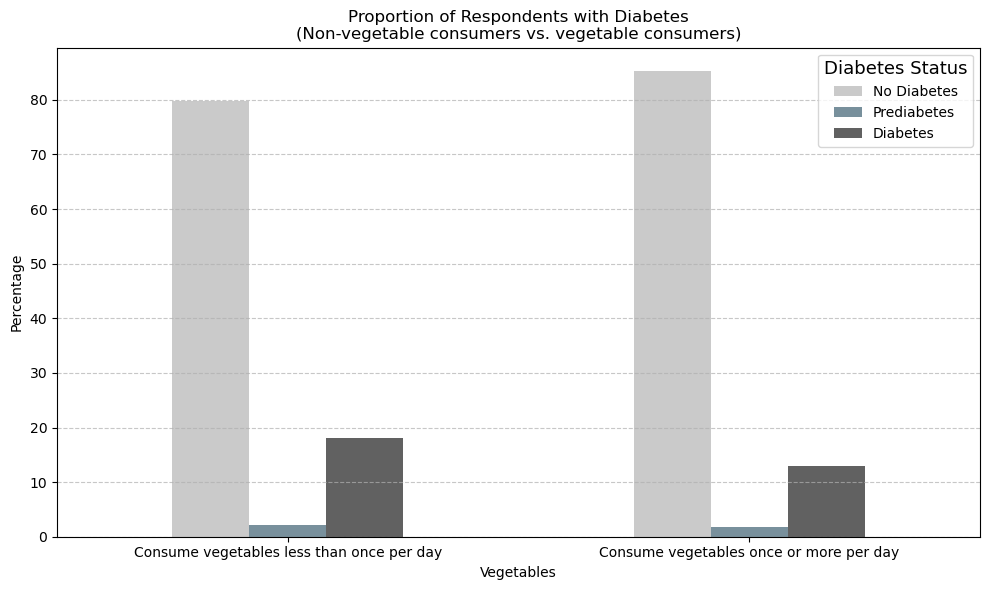

In [14]:
# Group by veg consumption and diabetes status, count the number of participants for each category
dia_veg = df_trimmed.groupby(["Veggies", "Diabetes_012"]).size().reset_index(name='count')

# Separate 0 veg values from 1 veg values, copying the tables so we can easily perform actions on them
noveg = dia_veg[dia_veg["Veggies"] == 0].copy()
yesveg = dia_veg[dia_veg["Veggies"] == 1].copy()

# Find the total respondents per category (veg and no veg)
# Create a new column for the proportion of respondents in each row out of their respective category
noveg_sum = noveg["count"].sum()
noveg["proportion"] = (noveg["count"] / noveg_sum) * 100

yesveg_sum = yesveg["count"].sum()
yesveg["proportion"] = (yesveg["count"] / yesveg_sum) * 100

# Using the pd.concat() function, combine the two tables into the new vegstack df, which shows the proportions
vegstack = pd.concat([noveg, yesveg], ignore_index=False)

# Pivot the table
veg_pivot_df = vegstack.pivot(index='Veggies', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
veg_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume vegetables less than once per day', 1.0: 'Consume vegetables once or more per day'}
veg_pivot_df.index = veg_pivot_df.index.map(index_mapping)

# Plot the table
veg_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-vegetable consumers vs. vegetable consumers)')
plt.xlabel('Vegetables')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(veg_pivot_df.index)), labels=veg_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Images/veg_vs_diabetes.png")
plt.show()

In [15]:
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(veg_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

Chi-squared statistic: 1.058840747315825
p-value: 0.5889462395188043
Degrees of freedom: 2
Expected frequencies:
[[82.52341063  1.98332244 15.49326693]
 [82.52341063  1.98332244 15.49326693]]
The p-value of the chi-squared test is 0.5889. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.


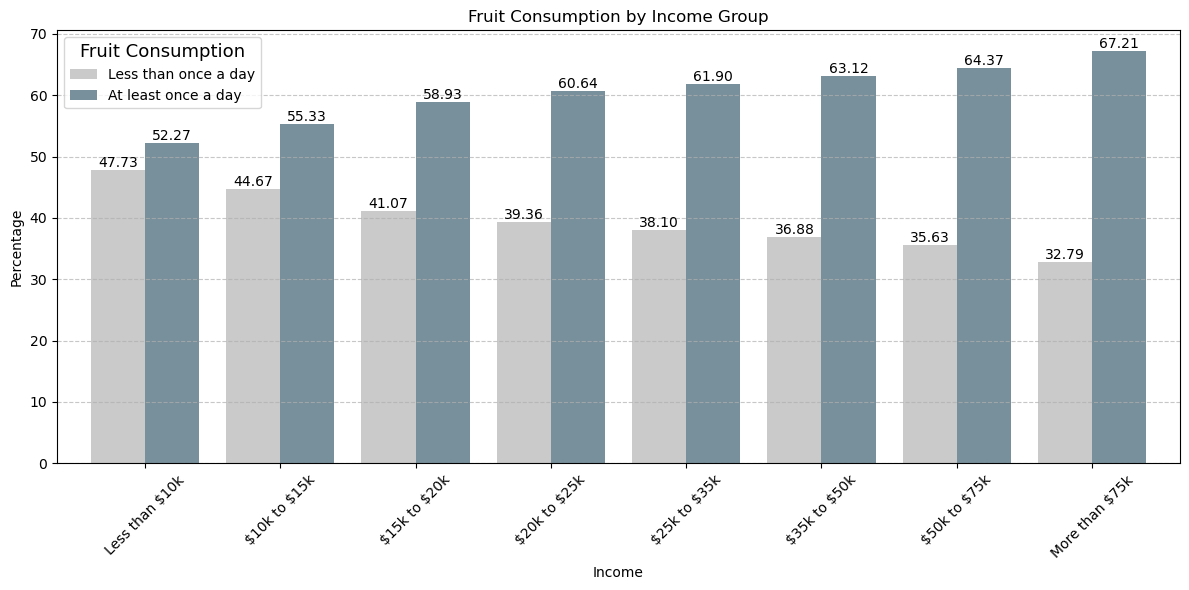

In [16]:
# Group by income and fruits, count the number of responses in each row
income_fruit = df_trimmed.groupby(['Income', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
incfruit_group_sum = income_fruit.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_fruit['proportion'] = (income_fruit['count'] / incfruit_group_sum) * 100

# Pivot the table
incfruit_pivot_df = income_fruit.pivot(index='Income', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
incfruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

incfruit_pivot_df.index = incfruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = incfruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(incfruit_pivot_df.index)), labels=incfruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/income_vs_fruit.png")
plt.show()

In [17]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(incfruit_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
incfruit_highlow = incfruit_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(incfruit_highlow)

# Output the results
print(f"For highest and lowest income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all income categories:
Chi-squared statistic: 6.943324033558531
p-value: 0.4348047374778161
Degrees of freedom: 7
Expected frequencies:
[[39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]
 [39.52858808 60.47141192]]
The p-value of the chi-squared test is 0.4348. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
For highest and lowest income categories:
Chi-squared statistic: 4.043770789078317
p-value: 0.044334654971304524
Degrees of freedom: 1
Expected frequencies:
[[40.25872235 59.74127765]
 [40.25872235 59.74127765]]
The p-value of the chi-squared test is 0.0443. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.


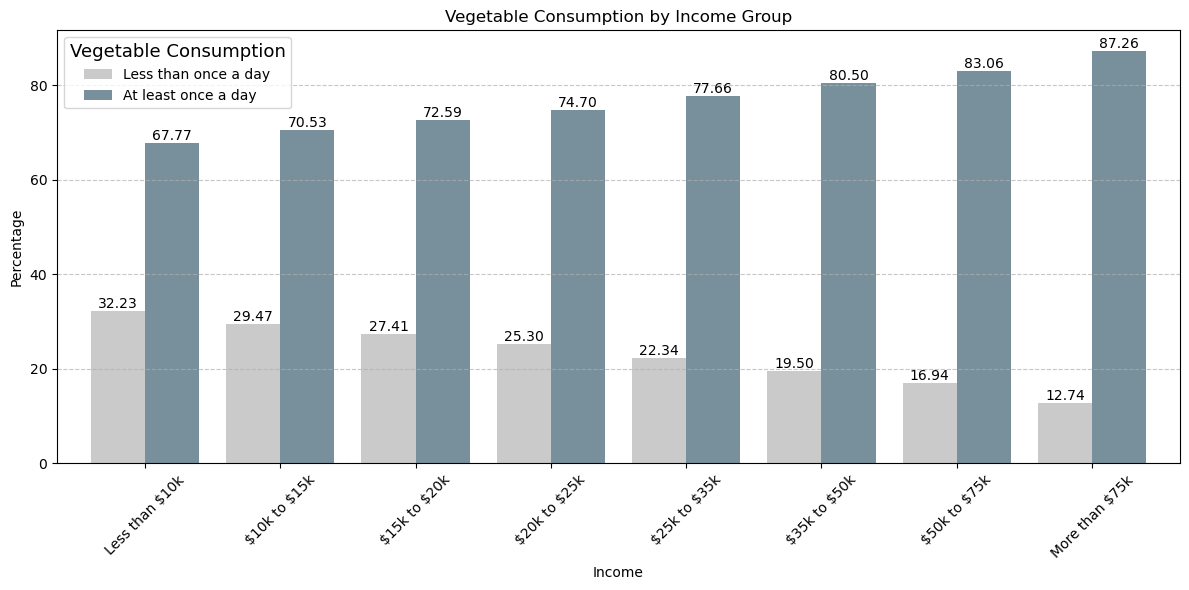

In [18]:
# Group by income and veggies, count the number of responses in each row
income_veg = df_trimmed.groupby(['Income', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
incveg_group_sum = income_veg.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_veg['proportion'] = (income_veg['count'] / incveg_group_sum) * 100

# Pivot the table
incveg_pivot_df = income_veg.pivot(index='Income', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
incveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

incveg_pivot_df.index = incveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = incveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(incveg_pivot_df.index)), labels=incveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/income_vs_veg.png")
plt.show()

In [19]:
# Run the Chi-squared test for all income categories
chi2, p, dof, expected = stats.chi2_contingency(incveg_pivot_df)

# Output the results
print(f"For all income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest income categories (the greatest difference in proportions)
incveg_highlow = incveg_pivot_df.loc[["Less than \$10k", "More than \$75k"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(incveg_highlow)

# Output the results
print(f"For highest and lowest income categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all income categories:
Chi-squared statistic: 17.155200073689883
p-value: 0.01642237116179022
Degrees of freedom: 7
Expected frequencies:
[[23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]
 [23.24007703 76.75992297]]
The p-value of the chi-squared test is 0.0164. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.
For highest and lowest income categories:
Chi-squared statistic: 9.809623435431151
p-value: 0.0017360104844295042
Degrees of freedom: 1
Expected frequencies:
[[22.4834318 77.5165682]
 [22.4834318 77.5165682]]
The p-value of the chi-squared test is 0.0017. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.


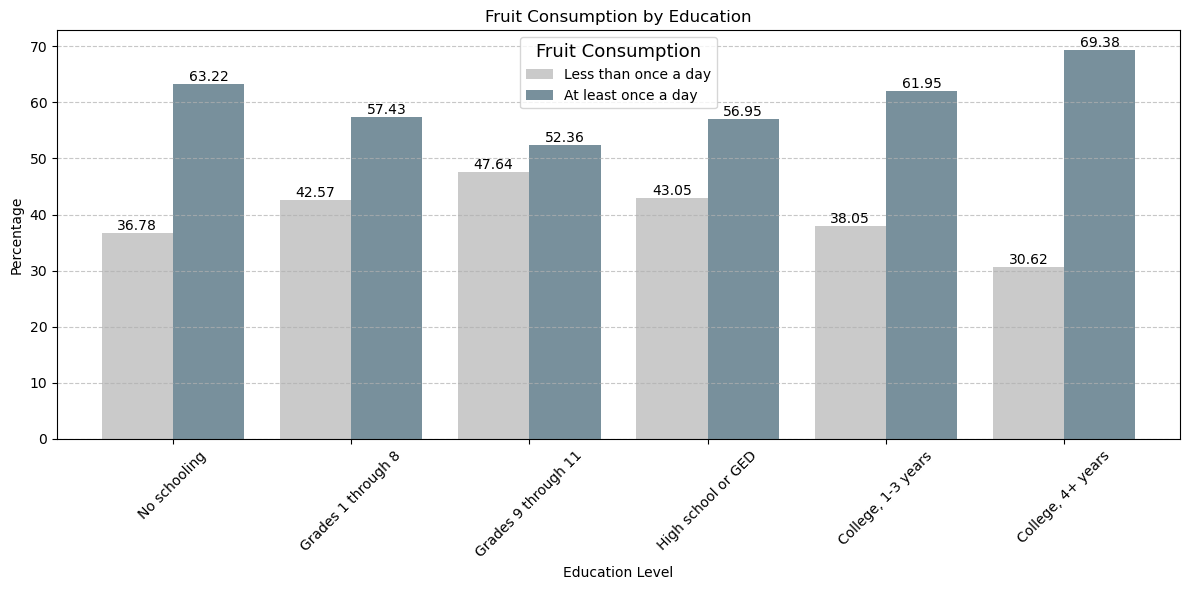

In [20]:
# Group by education and fruits, count the number of responses in each row
edu_fruit = df_trimmed.groupby(['Education', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
edufruit_group_sum = edu_fruit.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_fruit['proportion'] = (edu_fruit['count'] / edufruit_group_sum) * 100

# Pivot the table
edufruit_pivot_df = edu_fruit.pivot(index='Education', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
edufruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

edufruit_pivot_df.index = edufruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = edufruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edufruit_pivot_df.index)), labels=edufruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/education_vs_fruit.png")
plt.show()

In [21]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(edufruit_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
edufruit_highlow = edufruit_pivot_df.loc[["Grades 9 through 11", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(edufruit_highlow)

# Output the results
print(f"For the highest and lowest education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all education categories:
Chi-squared statistic: 7.344563181979858
p-value: 0.19624976011684742
Degrees of freedom: 5
Expected frequencies:
[[39.7848349 60.2151651]
 [39.7848349 60.2151651]
 [39.7848349 60.2151651]
 [39.7848349 60.2151651]
 [39.7848349 60.2151651]
 [39.7848349 60.2151651]]
The p-value of the chi-squared test is 0.1962. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
For the highest and lowest education categories:
Chi-squared statistic: 5.381948848273726
p-value: 0.020346137867177632
Degrees of freedom: 1
Expected frequencies:
[[39.13068507 60.86931493]
 [39.13068507 60.86931493]]
The p-value of the chi-squared test is 0.0203. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.


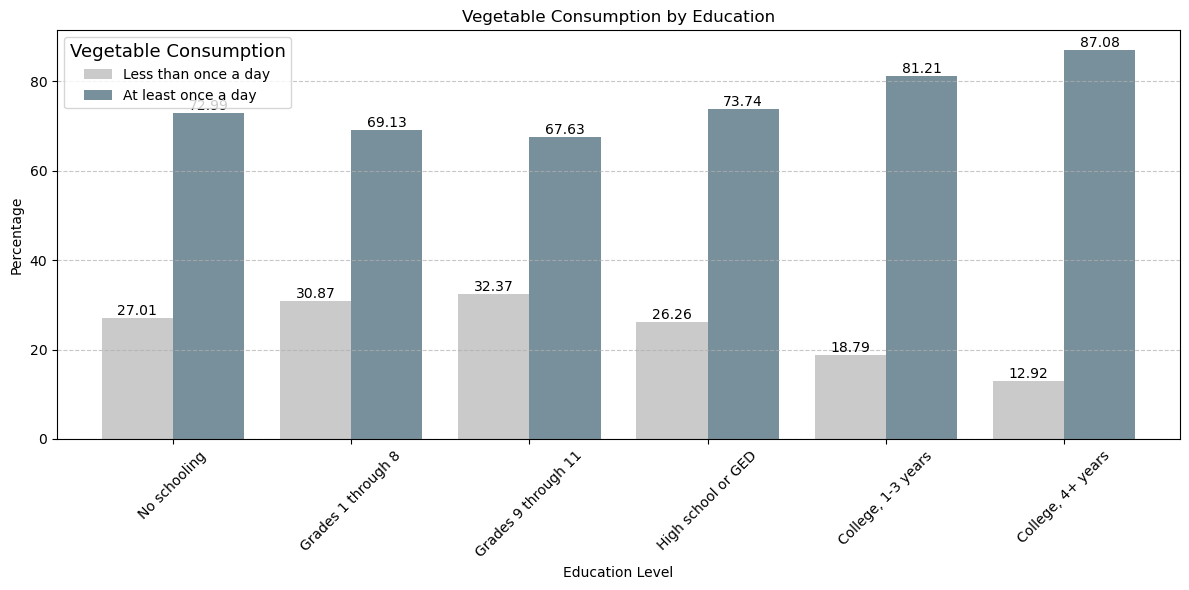

In [22]:
# Group by education and veggies, count the number of responses in each row
edu_veg = df_trimmed.groupby(['Education', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
eduveg_group_sum = edu_veg.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_veg['proportion'] = (edu_veg['count'] / eduveg_group_sum) * 100

# Pivot the table
eduveg_pivot_df = edu_veg.pivot(index='Education', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
eduveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

eduveg_pivot_df.index = eduveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = eduveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(eduveg_pivot_df.index)), labels=eduveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/education_vs_veg.png")
plt.show()

In [23]:
# Run the Chi-squared test for all education categories
chi2, p, dof, expected = stats.chi2_contingency(eduveg_pivot_df)

# Output the results
print(f"For all education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
eduveg_highlow = eduveg_pivot_df.loc[["Grades 9 through 11", "College, 4+ years"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(eduveg_highlow)

# Output the results
print(f"Between the highest and lowest education categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all education categories:
Chi-squared statistic: 14.969646834207571
p-value: 0.01049282266135244
Degrees of freedom: 5
Expected frequencies:
[[24.70248383 75.29751617]
 [24.70248383 75.29751617]
 [24.70248383 75.29751617]
 [24.70248383 75.29751617]
 [24.70248383 75.29751617]
 [24.70248383 75.29751617]]
The p-value of the chi-squared test is 0.0105. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.
Between the highest and lowest education categories:
Chi-squared statistic: 9.720982523965885
p-value: 0.0018217610042258775
Degrees of freedom: 1
Expected frequencies:
[[22.64280393 77.35719607]
 [22.64280393 77.35719607]]
The p-value of the chi-squared test is 0.0018. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.


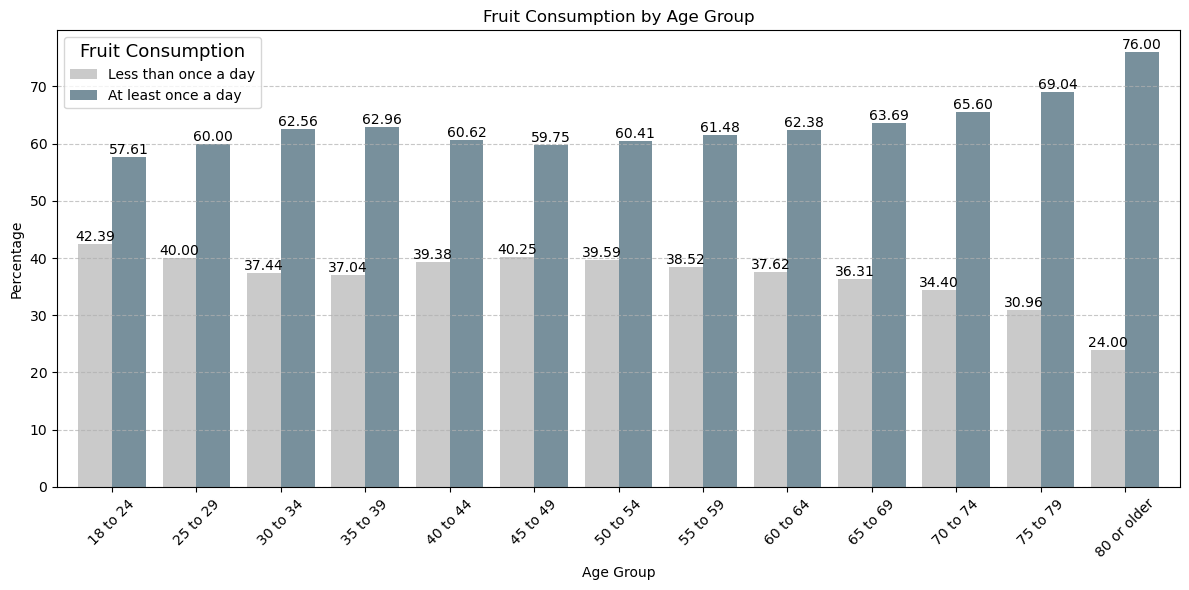

In [24]:
# Group by age and fruits, count the number of responses in each row
age_fruit = df_trimmed.groupby(['Age', 'Fruits']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
agefruit_group_sum = age_fruit.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_fruit['proportion'] = (age_fruit['count'] / agefruit_group_sum) * 100

# Pivot the table
agefruit_pivot_df = age_fruit.pivot(index='Age', columns='Fruits', values='proportion')

# Rename columns for easy display formatting
agefruit_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

agefruit_pivot_df.index = agefruit_pivot_df.index.map(index_mapping)

# Plot the table
ax = agefruit_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Fruit Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(agefruit_pivot_df.index)), labels=agefruit_pivot_df.index, rotation=45)
plt.legend(title='Fruit Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/age_vs_fruit.png")
plt.show()

In [25]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(agefruit_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest age categories (the greatest difference in proportions)
agefruit_highlow = agefruit_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(agefruit_highlow)

# Output the results
print(f"For highest and lowest age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all age categories:
Chi-squared statistic: 11.865410849438652
p-value: 0.45654840162539
Degrees of freedom: 12
Expected frequencies:
[[36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]
 [36.76145179 63.23854821]]
The p-value of the chi-squared test is 0.4565. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
For highest and lowest age categories:
Chi-squared statistic: 6.816101419067264
p-value: 0.009033956792275233
Degrees of freedom: 1
Expected frequencies:
[[33.19263689 66.80736311]
 [33.19263689 66.80736311]]
The p-value of the chi-squared test is 0.009. As this value is less than 0.05, we reject the null hypothesis. The samples are

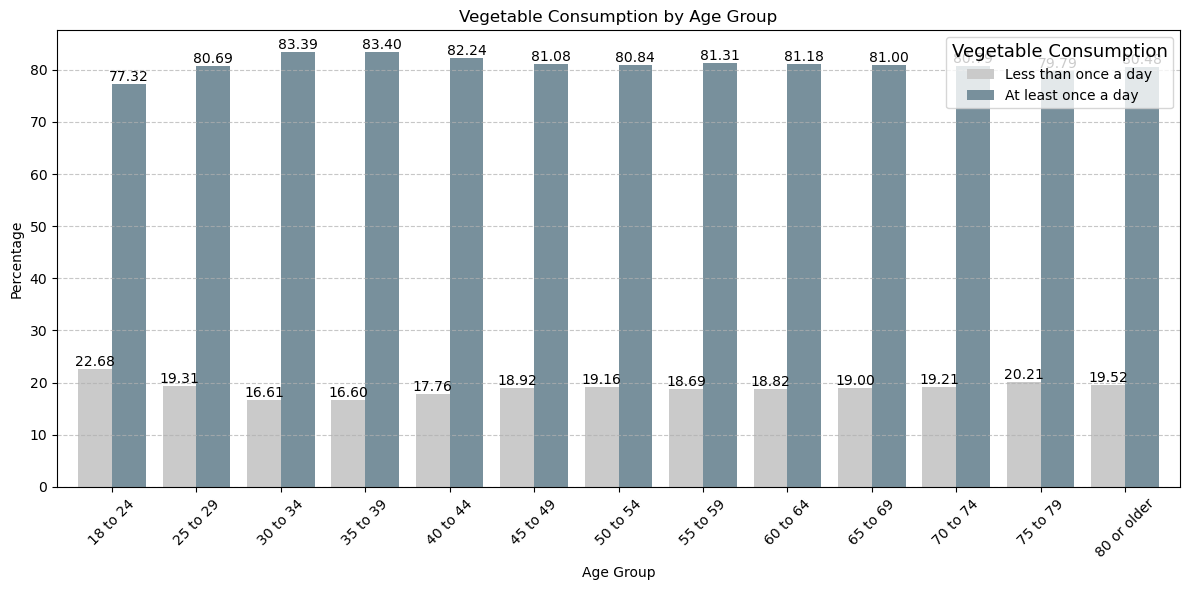

In [26]:
# Group by age and fruits, count the number of responses in each row
age_veg = df_trimmed.groupby(['Age', 'Veggies']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
ageveg_group_sum = age_veg.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_veg['proportion'] = (age_veg['count'] / ageveg_group_sum) * 100

# Pivot the table
ageveg_pivot_df = age_veg.pivot(index='Age', columns='Veggies', values='proportion')

# Rename columns for easy display formatting
ageveg_pivot_df.columns = ['Less than once a day', 'At least once a day']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

ageveg_pivot_df.index = ageveg_pivot_df.index.map(index_mapping)

# Plot the table
ax = ageveg_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Vegetable Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(ageveg_pivot_df.index)), labels=ageveg_pivot_df.index, rotation=45)
plt.legend(title='Vegetable Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/age_vs_veg.png")
plt.show()

In [27]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(ageveg_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest education categories (the greatest difference in proportions)
ageveg_highlow = agefruit_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(agefruit_highlow)

# Output the results
print(f"For highest and lowest age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all age categories:
Chi-squared statistic: 1.8611684411465403
p-value: 0.9995909140538747
Degrees of freedom: 12
Expected frequencies:
[[18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]
 [18.96055451 81.03944549]]
The p-value of the chi-squared test is 0.9996. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
For highest and lowest age categories:
Chi-squared statistic: 6.816101419067264
p-value: 0.009033956792275233
Degrees of freedom: 1
Expected frequencies:
[[33.19263689 66.80736311]
 [33.19263689 66.80736311]]
The p-value of the chi-squared test is 0.009. As this value is less than 0.05, we reject the null hypothesis. The samples a

### Summary:
Overall, significant correlations were found between diabetes and income, education, and age, with the strength of those significances increasing in that order. Although a trend can be observed in the provided charts, income was found to not have a significant correlation across all categories, but when the highest and lowest categories were compared, a very low p-value was returned in the Chi-squared test. The charts demonstrate that as income increases, diabetes rate decreases; as education level increases, diabetes rate decreases; and as age increases, diabetes rate increases.

Although fruit and vegetable consumption alone are not significantly correlated with diabetes outcome, they are significantly correlated with various demographic metrics which themselves are strongly correlated with diabetes. Fruit and vegetable consumption increases as income, education, and age increase. As diabetes outcome decreases when income and education increase, this could suggest a difference in lifestyle between groups which has an impact on diabetes outcome.

## Chinna - Physical Activity

In [30]:
# Group by PhysActivity and diabetes status, count the number of participants for each category
dia_PhysActivity = df_trimmed.groupby(["PhysActivity", "Diabetes_012"]).size().reset_index(name='count')


# Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
no_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 0].copy()
yes_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum = no_PhysActivity["count"].sum()
no_PhysActivity["proportion"] = (no_PhysActivity["count"] / no_PhysActivity_sum) * 100

yes_PhysActivity_sum = yes_PhysActivity["count"].sum()
yes_PhysActivity["proportion"] = (yes_PhysActivity["count"] / yes_PhysActivity_sum) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack = pd.concat([no_PhysActivity, yes_PhysActivity], ignore_index=False)
PhysActivitystack

,PhysActivity,Diabetes_012,count,proportion
0,0.0,0.0,47212,76.444301
1,0.0,1.0,1489,2.410946
2,0.0,2.0,13059,21.144754
3,1.0,0.0,166491,86.750208
4,1.0,1.0,3142,1.637140
5,1.0,2.0,22287,11.612651


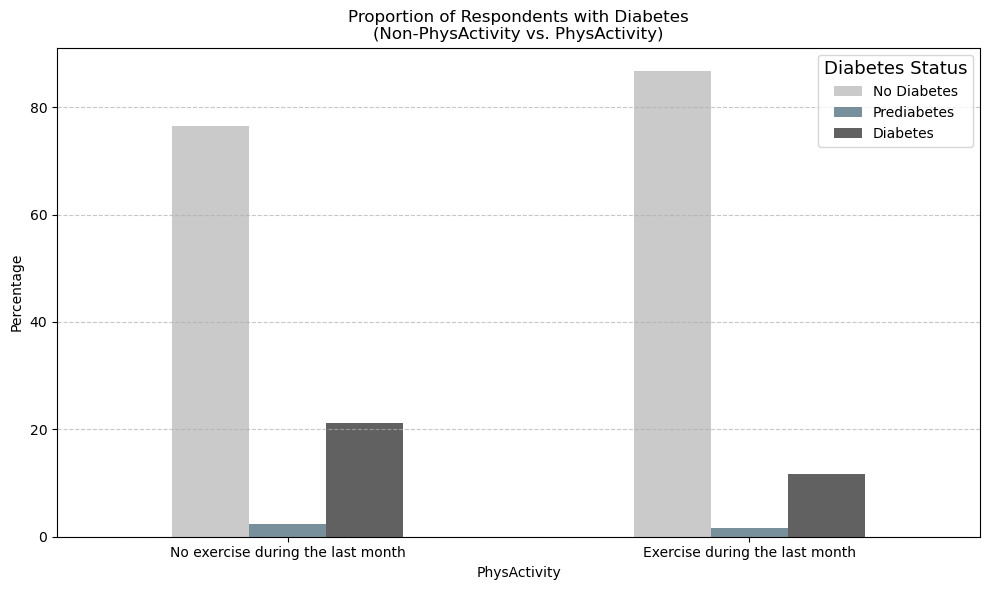

In [31]:
# Set up pivot table to reorganize PhysActivity df
PhysActivity_pivot_df = PhysActivitystack.pivot(index='PhysActivity', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
PhysActivity_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'No exercise during the last month', 1.0: 'Exercise during the last month'}
PhysActivity_pivot_df.index = PhysActivity_pivot_df.index.map(index_mapping)

# Plot the table
colors = ['#CACACA','#78909C','#616161']
PhysActivity_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-PhysActivity vs. PhysActivity)')
plt.xlabel('PhysActivity')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

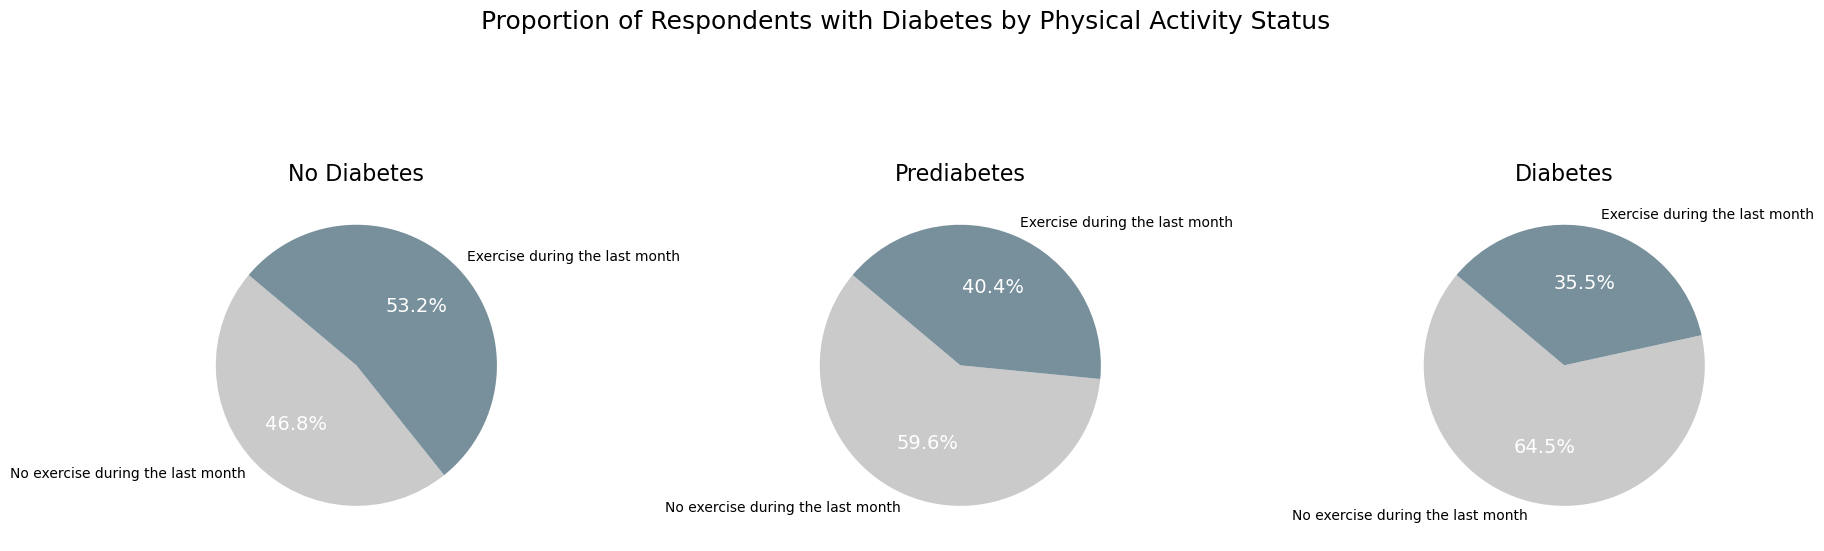

In [32]:

# PhysActivity Pie Chart

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# Define colors
colors = ['#CACACA','#78909C','#616161']

for i, column in enumerate(PhysActivity_pivot_df.columns):
    wedges, texts, autotexts = axes[i].pie(
        PhysActivity_pivot_df[column],
        labels=PhysActivity_pivot_df.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors[:len(PhysActivity_pivot_df.index)]  # Adjust colors to match number of slices
    )
    axes[i].set_title(column, fontsize=16, color='black')  # Title font size and color

    # Adjust font size and color for pie chart labels and percentages
    for text in texts:
        text.set_fontsize(10)
        text.set_color('black')  # Set color of pie chart labels
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')  # Set color of percentages

plt.suptitle('Proportion of Respondents with Diabetes by Physical Activity Status', fontsize=18)


plt.tight_layout()
plt.savefig("Images/dia_vs_physactivity_pie.png")
plt.show()


In [33]:
# #stacked bar chart PhysActivity

# #stacked bar chart PhysActivity
# data = {
#     'No Diabetes': [20, 30],
#     'Prediabetes': [15, 25],
#     'Diabetes': [10, 20]
# }
# PhysActivity_pivot_df = pd.DataFrame(data, index=['No exercise during the last month', 'Exercise during the last month'])

# # Define colors for each segment
# colors = ['#CACACA','#78909C','#616161']

# # Plotting the stacked bar chart
# ax = PhysActivity_pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# # Customize the chart
# plt.title('Proportion of Respondents with Diabetes by PhysActivity Status')
# plt.xlabel('PhysActivity')
# plt.ylabel('Percentage')
# plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
# plt.legend(title='Diabetes Status', title_fontsize='13', fontsize='11')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig("Images/dia_vs_physactivity_stackedbar.png")
# # Show the plot
# plt.show()

In [34]:
# #Doughnut Chart 
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# colors = ['#CACACA','#78909C','#616161']
# for i, column in enumerate(PhysActivity_pivot_df.columns):
#     wedges, texts, autotexts = axes[i].pie(PhysActivity_pivot_df[column], labels=PhysActivity_pivot_df.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4), colors=colors)
#     axes[i].set_title(column)

# plt.suptitle('Proportion of Respondents with Diabetes by Physical Activity Status')
# plt.tight_layout()
# plt.savefig("Images/dia_vs_physactivity_doughnut.png")
# plt.show()

In [35]:
#Chi square solution PhysActivity

# Example data for demonstration
data = {
    'PhysActivity': ['No exercise during the last month', 'Exercise during the last month'],
    'No Diabetes': [50, 30],
    'Prediabetes': [20, 15],
    'Diabetes': [10, 25]
}

PhysActivitystack = pd.DataFrame(data)
PhysActivitystack.set_index('PhysActivity', inplace=True)


from scipy.stats import chi2_contingency

# Prepare contingency table for Chi-Square test
contingency_table01 = PhysActivitystack.T  # Transpose to get counts in columns

contingency_table01



PhysActivity,No exercise during the last month,Exercise during the last month
No Diabetes,50,30
Prediabetes,20,15
Diabetes,10,25


In [36]:
# Perform Chi-Square test
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table01)

# Output the results
print(f'Chi-Square Statistic: {chi2_stat}')
print(f'P-Value: {p_val}')
print(f'Degrees of Freedom: {dof}')
print('Expected Frequencies:')
print(ex)
if p_val > 0.05:
    print(f"The p-value of the chi-squared test is {round(p_val,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The two samples are therefore not statistically different.")
else:
        print(f"The p-value of the chi-squared test is {round(p_val,4)}. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.")

Chi-Square Statistic: 11.52742346938776
P-Value: 0.0031394371877609584
Degrees of Freedom: 2
Expected Frequencies:
[[42.66666667 37.33333333]
 [18.66666667 16.33333333]
 [18.66666667 16.33333333]]
The p-value of the chi-squared test is 0.0031. As this value is less than 0.05, we reject the null hypothesis. The two samples are therefore statistically different.


In [37]:
#Fixed Chi-Square test/ updated percentage to correct count value.


# Create a contingency table
contingency_table02 = pd.crosstab(df_trimmed['Diabetes_012'], df_trimmed['PhysActivity'])

#Rename Column and Row Labels:
contingency_table02.columns = ['No exercise during the last month', 'Exercise during the last month']
contingency_table02.index = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table01)

# Print results
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# Interpretation of results

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Diabetes Status.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Diabetes Status.")

contingency_table02



Chi-Square Statistic: 11.52742346938776
P-Value: 0.0031394371877609584
Degrees of Freedom: 2
Expected Frequencies Table:
[[42.66666667 37.33333333]
 [18.66666667 16.33333333]
 [18.66666667 16.33333333]]
The p-value of the chi-squared test is 0.0031. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Diabetes Status.


,No exercise during the last month,Exercise during the last month
No Diabetes,47212,166491
Prediabetes,1489,3142
Diabetes,13059,22287


In [38]:
# #PhysActivity to Income
# # Group by PhysActivity and Income, count the number of participants for each category
# dia_PhysActivity_Income = df_trimmed.groupby(["PhysActivity", "Income"]).size().reset_index(name='count')


# # Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
# no_PhysActivity_Income = dia_PhysActivity_Income[dia_PhysActivity_Income["PhysActivity"] == 0].copy()
# yes_PhysActivity_Income = dia_PhysActivity_Income[dia_PhysActivity_Income["PhysActivity"] == 1].copy()

# # Find the total respondents per category (PhysActivity and no PhysActivity)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_PhysActivity_sum_Income = no_PhysActivity_Income["count"].sum()
# no_PhysActivity_Income["proportion"] = (no_PhysActivity_Income["count"] / no_PhysActivity_sum_Income) * 100

# yes_PhysActivity_sum_Income = yes_PhysActivity_Income["count"].sum()
# yes_PhysActivity_Income["proportion"] = (yes_PhysActivity_Income["count"] / yes_PhysActivity_sum_Income) * 100

# # Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
# PhysActivitystack_Income = pd.concat([no_PhysActivity_Income, yes_PhysActivity_Income], ignore_index=False)
# PhysActivitystack_Income





In [39]:
# PhysActivity_pivot_Income = PhysActivitystack_Income.pivot(index='Income', columns='PhysActivity', values='proportion')
# colors = ['#CACACA','#78909C','#616161']
# # Rename columns for clarity
# PhysActivity_pivot_Income.columns = ['No Physical Activity', 'Physical Activity']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# PhysActivity_pivot_Income.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# # Formatting
# plt.title('Proportion of Respondents by Income Level and Physical Activity Status')
# plt.xlabel('Income Level')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['Less than \$10k', '\$10k to \$15k', '\$15k to \$20k', '\$20k to \$25k', '\$25k to \$35k', '\$35k to \$50k', '\$50k to \$75k', 'More than \$75k'], rotation=45)
# plt.legend(title='Physical Activity Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [40]:
# #PhysActivity to Age
# # Group by PhysActivity and Age, count the number of participants for each category
# dia_PhysActivity_Age = df_trimmed.groupby(["PhysActivity", "Age"]).size().reset_index(name='count')


# # Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
# no_PhysActivity_Age = dia_PhysActivity_Age[dia_PhysActivity_Age["PhysActivity"] == 0].copy()
# yes_PhysActivity_Age = dia_PhysActivity_Age[dia_PhysActivity_Age["PhysActivity"] == 1].copy()

# # Find the total respondents per category (PhysActivity and no PhysActivity)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_PhysActivity_sum_Age = no_PhysActivity_Age["count"].sum()
# no_PhysActivity_Age["proportion"] = (no_PhysActivity_Age["count"] / no_PhysActivity_sum_Age) * 100

# yes_PhysActivity_sum_Age = yes_PhysActivity_Age["count"].sum()
# yes_PhysActivity_Age["proportion"] = (yes_PhysActivity_Age["count"] / yes_PhysActivity_sum_Age) * 100

# # Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
# PhysActivitystack_Age = pd.concat([no_PhysActivity_Age, yes_PhysActivity_Age], ignore_index=False)
# PhysActivitystack_Age



In [41]:
# PhysActivity_pivot_Age = PhysActivitystack_Age.pivot(index='Age', columns='PhysActivity', values='proportion')

# # Rename columns for clarity
# PhysActivity_pivot_Age.columns = ['No Physical Activity', 'Physical Activity']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# PhysActivity_pivot_Age.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# # Formatting
# plt.title('Proportion of Respondents by Age and Physical Activity Status')
# plt.xlabel('Age')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older' ], rotation=45)
# plt.legend(title='Physical Activity Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [42]:
# #PhysActivity to Education
# # Group by PhysActivity and Education, count the number of participants for each category
# dia_PhysActivity_Education = df_trimmed.groupby(["PhysActivity", "Education"]).size().reset_index(name='count')


# # Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
# no_PhysActivity_Education = dia_PhysActivity_Education[dia_PhysActivity_Education["PhysActivity"] == 0].copy()
# yes_PhysActivity_Education = dia_PhysActivity_Education[dia_PhysActivity_Education["PhysActivity"] == 1].copy()

# # Find the total respondents per category (PhysActivity and no PhysActivity)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_PhysActivity_sum_Education = no_PhysActivity_Education["count"].sum()
# no_PhysActivity_Education["proportion"] = (no_PhysActivity_Education["count"] / no_PhysActivity_sum_Education) * 100

# yes_PhysActivity_sum_Education = yes_PhysActivity_Education["count"].sum()
# yes_PhysActivity_Education["proportion"] = (yes_PhysActivity_Education["count"] / yes_PhysActivity_sum_Education) * 100

# # Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
# PhysActivitystack_Education = pd.concat([no_PhysActivity_Education, yes_PhysActivity_Education], ignore_index=False)
# PhysActivitystack_Education


In [43]:
# PhysActivity_pivot_Education = PhysActivitystack_Education.pivot(index='Education', columns='PhysActivity', values='proportion')

# # Rename columns for clarity
# PhysActivity_pivot_Education.columns = ['No Physical Activity', 'Physical Activity']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# PhysActivity_pivot_Education.plot(kind='bar', ax=ax, color=['#CACACA', '#78909c'])

# # Formatting
# plt.title('Proportion of Respondents by Education and Physical Activity Status')
# plt.xlabel('Education')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['No Schooling', 'Grades 1 through 8', 'Grades 9 through 11', 'High School or GED', 'College, 1-3 years', 'College, 4+ years'], rotation=45)
# plt.legend(title='Physical Activity Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [44]:
# #Chi_square test Income
# # Create a contingency table
# contingency_table03 = pd.crosstab(df_trimmed['Income'], df_trimmed['PhysActivity'])

# #Rename Column and Row Labels:
# contingency_table03.columns = ['No exercise during the last month', 'Exercise during the last month']
# contingency_table03.index = ['Less than \$10k', '\$10k to \$15k', '\$15k to \$20k', '\$20k to \$25k', '\$25k to \$35k', '\$35k to \$50k', '\$50k to \$75k', 'More than \$75k']

# # Perform the Chi-Square test
# chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table03)

# # Print results
# print("Chi-Square Statistic:", chi2_stat)
# print("P-Value:", p_value)
# print("Degrees of Freedom:", dof)
# print("Expected Frequencies Table:")
# print(expected)

# # Interpretation of results

# if p_value < 0.05:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Income range.")
# else:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Income range.")

# contingency_table03

In [45]:
# contingency_table04 = pd.crosstab(df_trimmed['Age'], df_trimmed['PhysActivity'])

# #Rename Column and Row Labels:
# contingency_table04.columns = ['No exercise during the last month', 'Exercise during the last month']
# contingency_table04.index = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# # Perform the Chi-Square test
# chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table04)

# # Print results
# print("Chi-Square Statistic:", chi2_stat)
# print("P-Value:", p_value)
# print("Degrees of Freedom:", dof)
# print("Expected Frequencies Table:")
# print(expected)

# # Interpretation of results

# if p_value < 0.05:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Age range.")
# else:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Age range.")

# contingency_table04

In [46]:
# contingency_table05 = pd.crosstab(df_trimmed['Education'], df_trimmed['PhysActivity'])

# #Rename Column and Row Labels:
# contingency_table05.columns = ['No exercise during the last month', 'Exercise during the last month']
# contingency_table05.index = ['No Schooling', 'Grades 1 through 8', 'Grades 9 through 11', 'High School or GED', 'College, 1-3 years', 'College, 4+ years']

# # Perform the Chi-Square test
# chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table05)

# # Print results
# print("Chi-Square Statistic:", chi2_stat)
# print("P-Value:", p_value)
# print("Degrees of Freedom:", dof)
# print("Expected Frequencies Table:")
# print(expected)

# # Interpretation of results

# if p_value < 0.05:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Education range.")
# else:
#     print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Education range.")

# contingency_table05

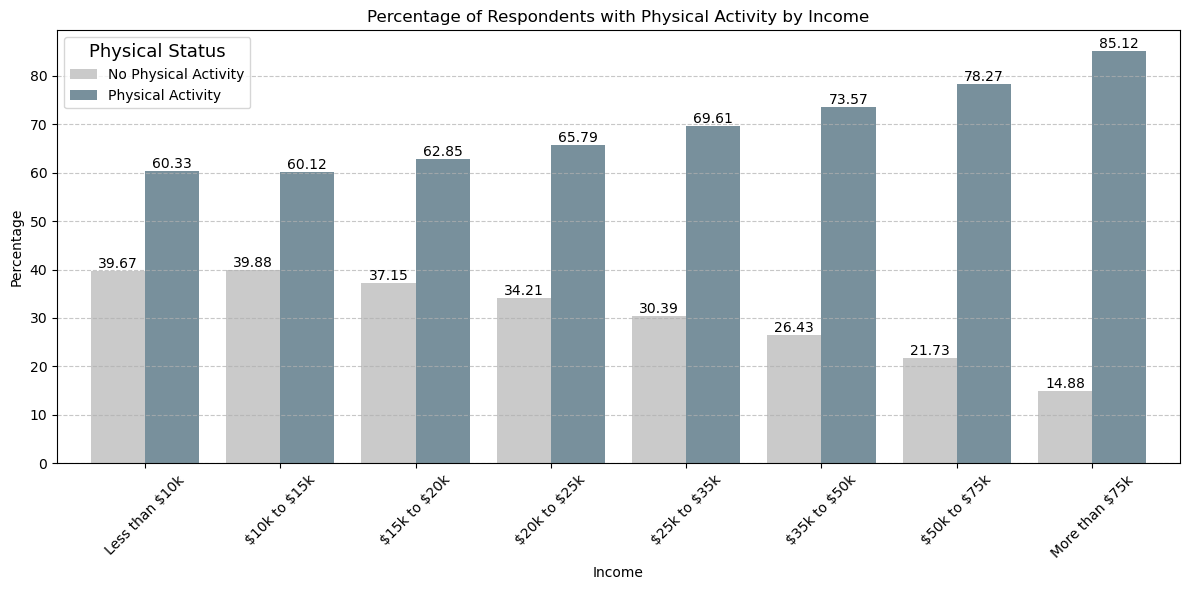

In [47]:
# Group by income and physical activity, count the number of responses in each row
dia_income_PhysActivity02 = df_trimmed.groupby(["Income", "PhysActivity"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_group_sum_PhysActivity02 = dia_income_PhysActivity02.groupby('Income')['count'].transform('sum')

# Calculate the proportions
dia_income_PhysActivity02['proportion'] = (dia_income_PhysActivity02['count'] / income_group_sum_PhysActivity02) * 100

# Pivot the table
income_pivot_df_PhysActivity02 = dia_income_PhysActivity02.pivot(index='Income', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
income_pivot_df_PhysActivity02.columns = ['No Physical Activity', 'Physical Activity']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }
income_pivot_df_PhysActivity02.index = income_pivot_df_PhysActivity02.index.map(index_mapping)

# Plot the table
ax = income_pivot_df_PhysActivity02.plot(kind='bar', width = .8, figsize=(12, 6), color=['#CACACA', '#78909c'])
plt.title('Percentage of Respondents with Physical Activity by Income')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_pivot_df_PhysActivity02.index)), labels=income_pivot_df_PhysActivity02.index, rotation=45)
plt.legend(title='Physical Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
#ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/income_vs_physactivity.png")
plt.show()

In [48]:
#Chi_square test Income with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(income_pivot_df_PhysActivity02)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Income range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Income range.")


Chi-squared statistic: 26.75970670463959
p-value: 0.00036814672696583
Degrees of freedom: 7
Expected frequencies:
[[30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]
 [30.54081828 69.45918172]]
The p-value of the chi-squared test is 0.0031. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Income range.


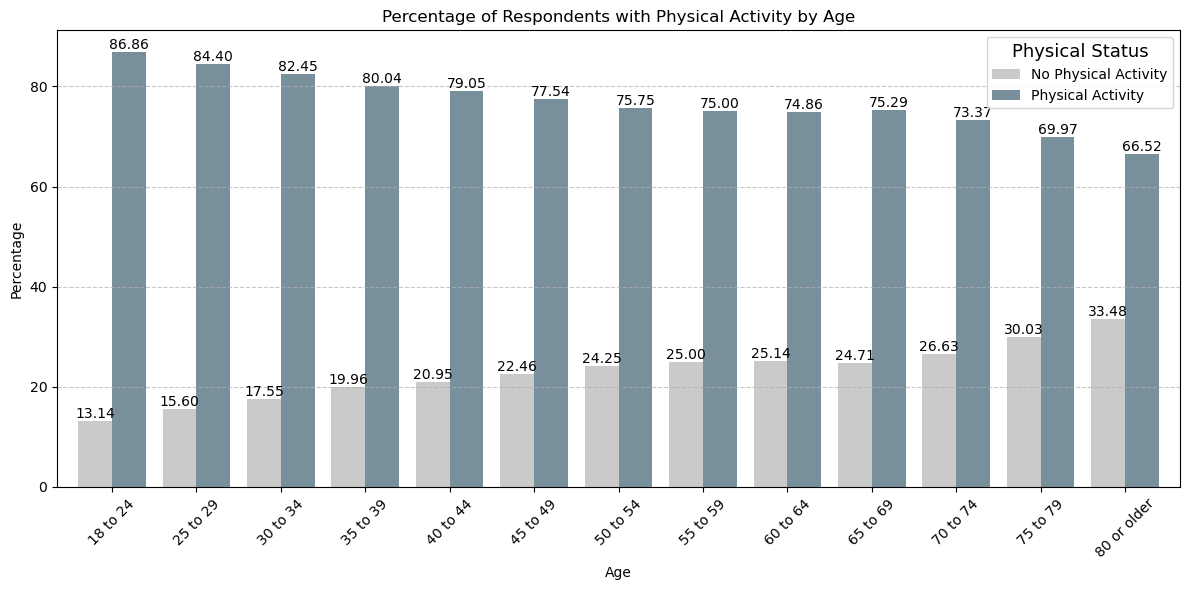

In [49]:
# Group by age and physactivity, count the number of responses in each row

dia_age_PhysActivity02 = df_trimmed.groupby(["Age", "PhysActivity"]).size().reset_index(name='count')

# Calculate the sum of responses for each income group
age_group_sum_PhysActivity02 = dia_age_PhysActivity02.groupby('Age')['count'].transform('sum')

# Calculate the proportions
dia_age_PhysActivity02['proportion'] = (dia_age_PhysActivity02['count'] / age_group_sum_PhysActivity02) * 100

# Pivot the table
age_pivot_df_PhysActivity02 = dia_age_PhysActivity02.pivot(index='Age', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
age_pivot_df_PhysActivity02.columns = ['No Physical Activity', 'Physical Activity']


# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

age_pivot_df_PhysActivity02.index = age_pivot_df_PhysActivity02.index.map(index_mapping)

# Plot the table
ax = age_pivot_df_PhysActivity02.plot(kind='bar', width = .8, figsize=(12, 6), color=['#CACACA', '#78909c'])
plt.title('Percentage of Respondents with Physical Activity by Age')
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_pivot_df_PhysActivity02.index)), labels=age_pivot_df_PhysActivity02.index, rotation=45)
plt.legend(title='Physical Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')
#ax.bar_label(ax.containers[2], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/age_vs_PhysActivity.png")
plt.show()

In [50]:
#Chi_square test Age with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(age_pivot_df_PhysActivity02)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Age range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Age range.")



Chi-squared statistic: 21.516434256653678
p-value: 0.04331060895425237
Degrees of freedom: 12
Expected frequencies:
[[22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]
 [22.99145078 77.00854922]]
The p-value of the chi-squared test is 0.0031. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Age range.


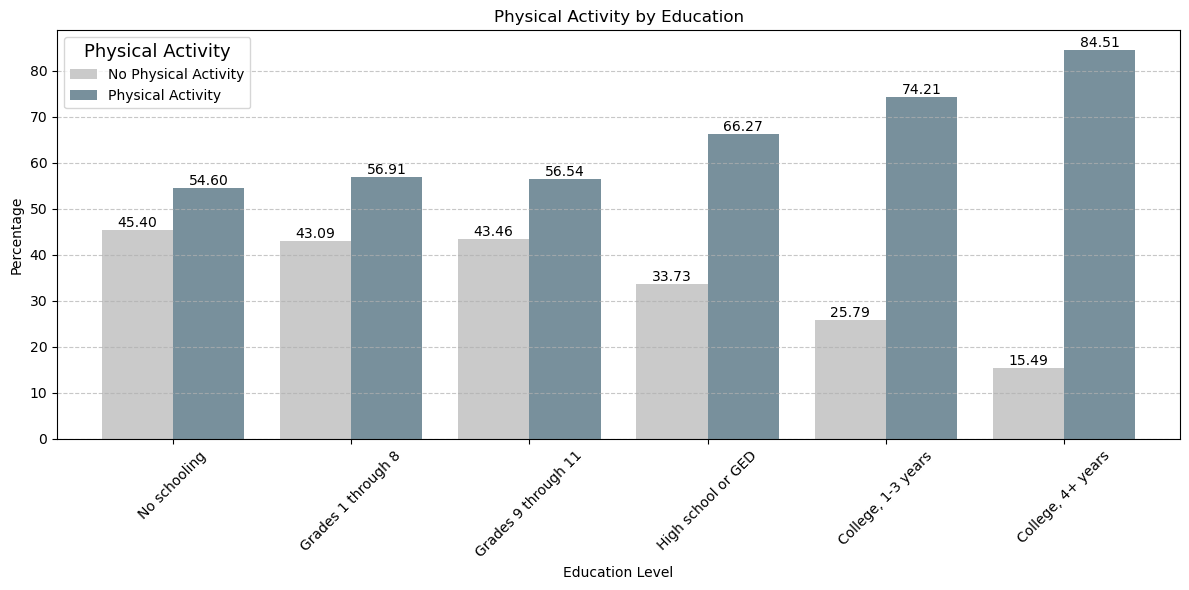

In [51]:
# Group by education and physical activity, count the number of responses in each row
edu_physactivity = df_trimmed.groupby(['Education', 'PhysActivity']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
eduphysactivity_group_sum = edu_physactivity.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_physactivity['proportion'] = (edu_physactivity['count'] / eduphysactivity_group_sum) * 100

# Pivot the table
eduphysactivity_pivot_df = edu_physactivity.pivot(index='Education', columns='PhysActivity', values='proportion')

# Rename columns for easy display formatting
eduphysactivity_pivot_df.columns = ['No Physical Activity', 'Physical Activity']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

eduphysactivity_pivot_df.index = eduphysactivity_pivot_df.index.map(index_mapping)

# Plot the table
ax = eduphysactivity_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Physical Activity by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(eduphysactivity_pivot_df.index)), labels=eduphysactivity_pivot_df.index, rotation=45)
plt.legend(title='Physical Activity', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/education_vs_physactivity.png")
plt.show()

In [52]:
#Chi_square test Education with corrected proportion percentage
# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(eduphysactivity_pivot_df)

# Output the results
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

if p_value < 0.05:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Education range.")
else:
    print(f"The p-value of the chi-squared test is {round(p_value,4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between Physical Activity and Education range.")



Chi-squared statistic: 31.447974563871927
p-value: 7.640186592719318e-06
Degrees of freedom: 5
Expected frequencies:
[[34.492425 65.507575]
 [34.492425 65.507575]
 [34.492425 65.507575]
 [34.492425 65.507575]
 [34.492425 65.507575]
 [34.492425 65.507575]]
The p-value of the chi-squared test is 0.0031. As this value is less than 0.05, we reject the null hypothesis. There is a significant association between Physical Activity and Education range.


### Summary:

The analysis reveals that physical activity is influenced by several demographic factors: diabetes status, income, age, and education level. Individuals with diabetes are less active compared to those without diabetes or prediabetes. Higher income is associated with greater physical activity, while lower income correlates with more inactivity. Younger individuals are more active than older ones, who show higher inactivity rates. Additionally, higher education levels are linked to more physical activity, whereas lower education levels are associated with higher inactivity rates. These factors highlight the complex interplay of socio-economic and health-related variables on lifestyle behaviors.

## Abigail - Recent Cholesterol Check

In [55]:
# Group by cholesterol check status and diabetes status
dia_chol_check = df_trimmed.groupby(["CholCheck", "Diabetes_012"]).size().reset_index(name='count')
colors = ['#CACACA','#78909C','#616161']

# Separate the categories of those who did not have a cholesterol check (0) and those who did (1)
nocholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 0].copy()
yescholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 1].copy()
colors = ['#CACACA','#78909C','#616161']

# Find the total respondents per category (cholesterol check and no cholesterol check)
# Create a new column for the proportion of respondents in each row out of their respective category
nocholcheck_sum = nocholcheck["count"].sum()
nocholcheck["proportion"] = (nocholcheck["count"] / nocholcheck_sum) * 100

yescholcheck_sum = yescholcheck["count"].sum()
yescholcheck["proportion"] = (yescholcheck["count"] / yescholcheck_sum) * 100

# Using the pd.concat() function, combine the two tables into a new DataFrame that shows the proportions
cholcheck_stack = pd.concat([nocholcheck, yescholcheck], ignore_index=False)
cholcheck_stack


,CholCheck,Diabetes_012,count,proportion
0,0.0,0.0,9167,96.800422
1,0.0,1.0,62,0.654699
2,0.0,2.0,241,2.544879
3,1.0,0.0,204536,83.754146
4,1.0,1.0,4569,1.870931
5,1.0,2.0,35105,14.374923


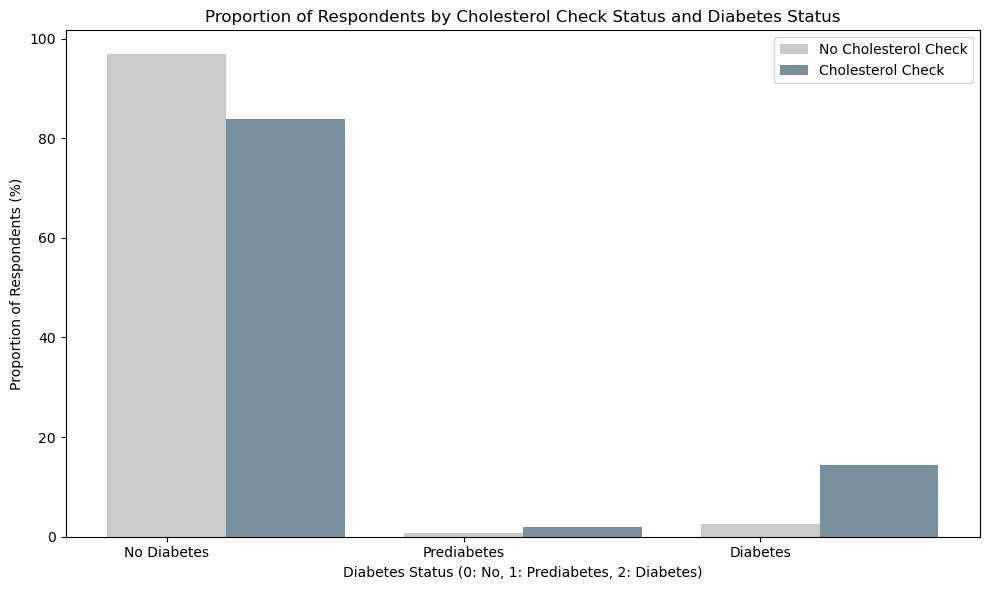

In [56]:
# Plot the proportions for cholesterol check status and diabetes status
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for the diabetes statuses
# colors = ['#CACACA','#78909C','#616161']

# Plot the no cholesterol check group
ax.bar(nocholcheck["Diabetes_012"], nocholcheck["proportion"], width=0.4, label="No Cholesterol Check", color=['#CACACA'], align='center')

# Plot the yes cholesterol check group, shifted slightly to the right
ax.bar(yescholcheck["Diabetes_012"] + 0.4, yescholcheck["proportion"], width=0.4, label="Cholesterol Check", color=['#78909C'], align='center')

# Set the labels and title
ax.set_xlabel("Diabetes Status (0: No, 1: Prediabetes, 2: Diabetes)")
ax.set_ylabel("Proportion of Respondents (%)")
ax.set_title("Proportion of Respondents by Cholesterol Check Status and Diabetes Status")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['No Diabetes', 'Prediabetes', 'Diabetes'])

# Add a legend
ax.legend()

# Display the plot
plt.savefig("Images/cholesterol_vs_diabetes.png")
plt.tight_layout()
plt.show()

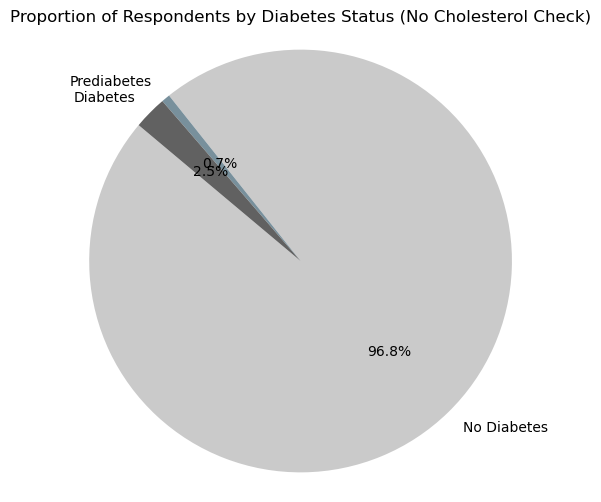

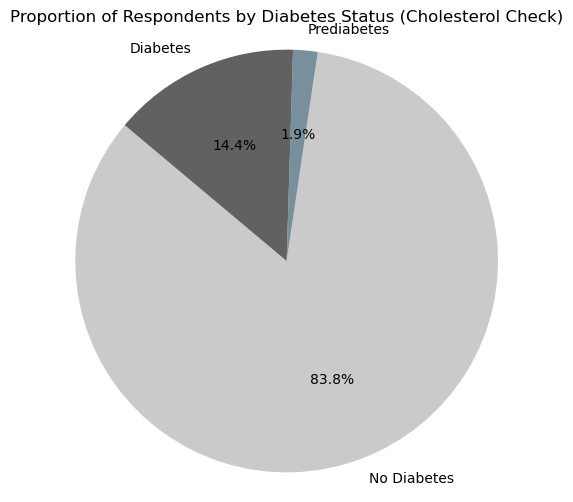

In [57]:

# Group by cholesterol check status and diabetes status
dia_chol_check = df_trimmed.groupby(["CholCheck", "Diabetes_012"]).size().reset_index(name='count')

# Separate the categories of those who did not have a cholesterol check (0) and those who did (1)
nocholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 0].copy()
yescholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 1].copy()

# Find the total respondents per category (cholesterol check and no cholesterol check)
# Create a new column for the proportion of respondents in each row out of their respective category
nocholcheck_sum = nocholcheck["count"].sum()
nocholcheck["proportion"] = (nocholcheck["count"] / nocholcheck_sum) * 100

yescholcheck_sum = yescholcheck["count"].sum()
yescholcheck["proportion"] = (yescholcheck["count"] / yescholcheck_sum) * 100

# Combine the two tables into a new DataFrame that shows the proportions
cholcheck_stack = pd.concat([nocholcheck, yescholcheck], ignore_index=True)

# Plot the data as pie charts
for chol_check_status, title in [(0, "No Cholesterol Check"), (1, "Cholesterol Check")]:
    # Filter the data for the current cholesterol check status
    data = cholcheck_stack[cholcheck_stack["CholCheck"] == chol_check_status]
    
    # Create the pie chart
    labels = ['No Diabetes', 'Prediabetes', 'Diabetes']
    sizes = data['proportion'].values
    colors = ['#CACACA','#78909C','#616161']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors = colors, autopct='%1.1f%%', startangle=140)
    plt.title(f"Proportion of Respondents by Diabetes Status ({title})")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig("Images/cholesterol_vs_diabetes.png")
    plt.show()


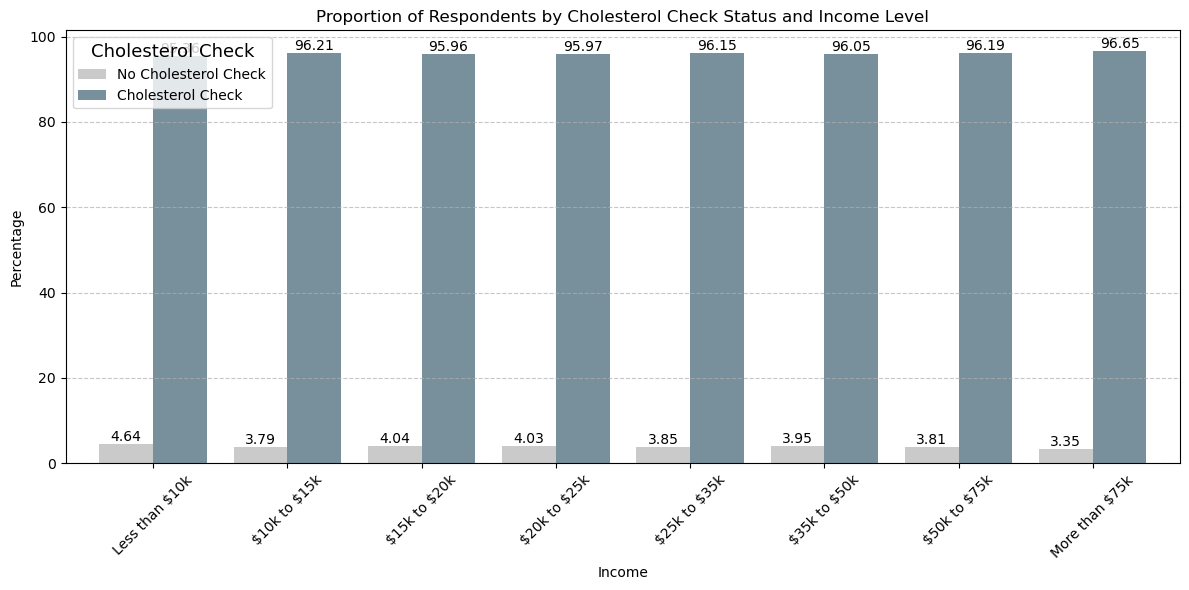

In [58]:
# Group by income and chol check, count the number of responses in each row
income_chol = df_trimmed.groupby(['Income', 'CholCheck']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
incchol_group_sum = income_chol.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_chol['proportion'] = (income_chol['count'] / incchol_group_sum) * 100

# Pivot the table
incchol_pivot_df = income_chol.pivot(index='Income', columns='CholCheck', values='proportion')

# Rename columns for easy display formatting
incchol_pivot_df.columns = ['No Cholesterol Check', 'Cholesterol Check']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

incchol_pivot_df.index = incchol_pivot_df.index.map(index_mapping)

# Plot the table
ax = incchol_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Proportion of Respondents by Cholesterol Check Status and Income Level')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(incchol_pivot_df.index)), labels=incchol_pivot_df.index, rotation=45)
plt.legend(title='Cholesterol Check', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/cholesterol_vs_income.png")
plt.show()

In [59]:

# # Group by income
# # Define the income scale mapping 
# income_scale = {
#     1: 'Less than $10,000',
#     2: '$10,000 to less than $15,000',
#     3: '$15,000 to less than $20,000',
#     4: '$20,000 to less than $25,000',
#     5: '$25,000 to less than $35,000',
#     6: '$35,000 to less than $50,000',
#     7: '$50,000 to less than $75,000',
#     8: '$75,000 or more'
# }

# # Map the Income column to the descriptive categories
# diabetes_df['Income'] = diabetes_df['Income'].map(income_scale)


# # Group by income, cholesterol check status, and diabetes status
# dia_income_chol = diabetes_df.groupby(["Income", "CholCheck", "Diabetes_012"]).size().reset_index(name='count')

# # Separate categories based on cholesterol check status
# nocholcheck_income = dia_income_chol[dia_income_chol["CholCheck"] == 0].copy()
# yescholcheck_income = dia_income_chol[dia_income_chol["CholCheck"] == 1].copy()

# # Calculate proportions
# nocholcheck_income_sum = nocholcheck_income.groupby("Income")["count"].transform('sum')
# nocholcheck_income["proportion"] = (nocholcheck_income["count"] / nocholcheck_income_sum) * 100

# yescholcheck_income_sum = yescholcheck_income.groupby("Income")["count"].transform('sum')
# yescholcheck_income["proportion"] = (yescholcheck_income["count"] / yescholcheck_income_sum) * 100

# # Plot the proportions for cholesterol check status and diabetes status by income
# fig, ax = plt.subplots(figsize=(12, 8))

# # Colors for diabetes statuses
# colors = ['#CACACA','#78909C','#616161']

# # Plot the no cholesterol check group
# ax.bar(nocholcheck_income["Income"], nocholcheck_income["proportion"], width=0.4, label="No Cholesterol Check", color=colors, align='center')

# # Plot the yes cholesterol check group, shifted slightly to the right
# ax.bar(yescholcheck_income["Income"], yescholcheck_income["proportion"], width=0.4, label="Cholesterol Check", color=colors, align='center')

# # Set the labels and title
# ax.set_xlabel("Income Level")
# ax.set_ylabel("Proportion of Respondents (%)")
# ax.set_title("Proportion of Respondents by Cholesterol Check Status and Income Level")
# ax.set_xticks(range(len(income_scale)))
# ax.set_xticklabels(list(income_scale.values()), rotation=45, ha="right")

# # Add a legend
# ax.legend()

# # Display the plot
# plt.savefig("images/cholesterol_vs_income.png")
# plt.tight_layout()
# plt.show()


In [60]:
# Create a chi squared test for cholesterol check vs income

from scipy.stats import chi2_contingency  # Import Chi-Square test function

contingency_table = pd.crosstab(diabetes_df['Income'], diabetes_df['CholCheck'])
chi2, p, dof, expected = chi2_contingency(contingency_table)


# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)


# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("\nThere is a statistically significant association between income level and cholesterol check status (p < 0.05).")
else:
    print("\nThere is no statistically significant association between income level and cholesterol check status (p >= 0.05).")

Contingency Table:
CholCheck   0.0    1.0
Income                
1.0         455   9356
2.0         446  11337
3.0         646  15348
4.0         811  19324
5.0         996  24887
6.0        1441  35029
7.0        1645  41574
8.0        3030  87355

Chi-Square Test Results:
Chi-Square Statistic: 74.34581402151778
P-Value: 1.9470932694446176e-13
Degrees of Freedom: 7

Expected Frequencies:
[[  366.24948754  9444.75051246]
 [  439.8652239  11343.1347761 ]
 [  597.06393882 15396.93606118]
 [  751.64951908 19383.35048092]
 [  966.22520498 24916.77479502]
 [ 1361.44315673 35108.55684327]
 [ 1613.38666824 41605.61333176]
 [ 3374.11680069 87010.88319931]]

There is a statistically significant association between income level and cholesterol check status (p < 0.05).


Diabetes_012       0.0       1.0       2.0
Income                                    
1.0           0.941383  0.974522  0.987411
2.0           0.951325  0.985955  0.988658
3.0           0.949938  0.973872  0.990471
4.0           0.950839  0.980392  0.991613
5.0           0.954165  0.986371  0.992229
6.0           0.953699  0.995989  0.994519
7.0           0.956608  0.985034  0.996391
8.0           0.963519  0.993076  0.996525


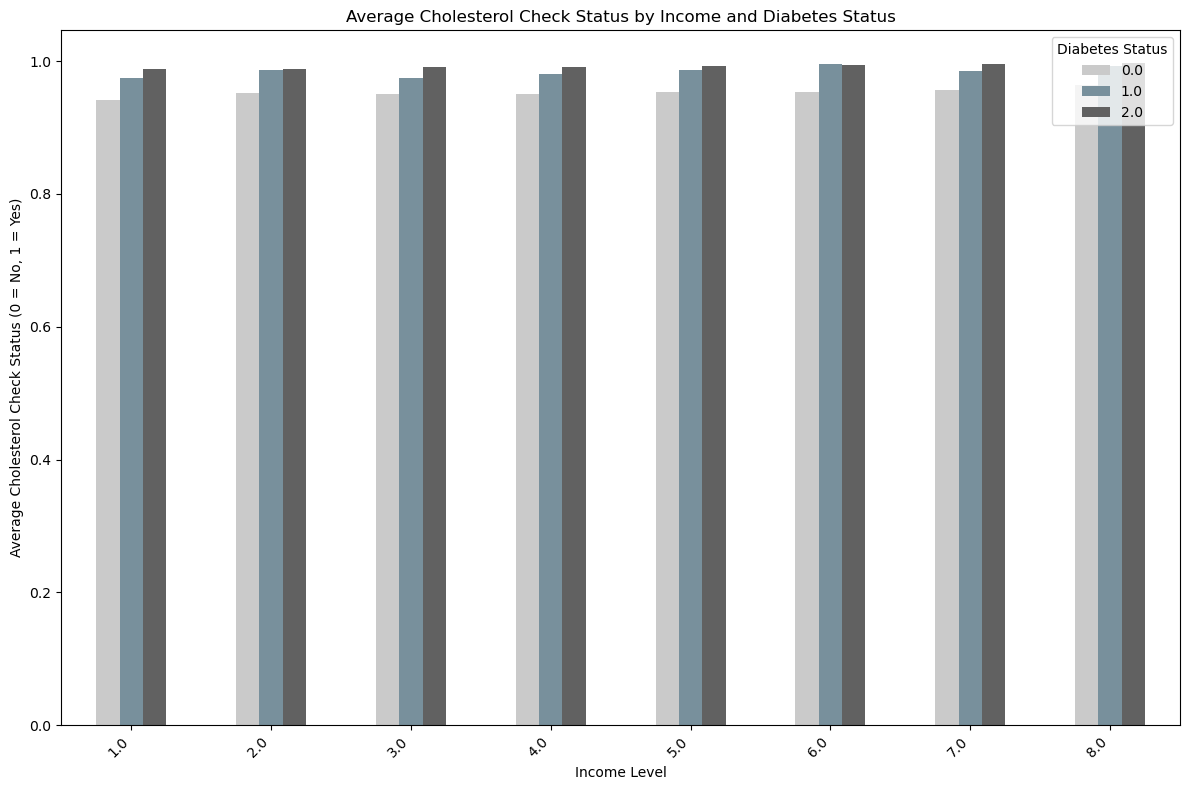

In [61]:
# Create a pivot table to summarize cholesterol check status by income and diabetes status
pivot_table = diabetes_df.pivot_table(
    values='CholCheck', 
    index='Income', 
    columns='Diabetes_012', 
    aggfunc='mean'
)

# Display the pivot table
print(pivot_table)

# Plot the pivot table as a bar plot using the specified colors
pivot_table.plot(kind='bar', figsize=(12, 8), color=['#CACACA','#78909C','#616161'])

# Customize the plot
plt.title("Average Cholesterol Check Status by Income and Diabetes Status")
plt.ylabel("Average Cholesterol Check Status (0 = No, 1 = Yes)")
plt.xlabel("Income Level")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Diabetes Status", loc='upper right')

# Show the plot
plt.savefig("Images/cholesterol_vs_income.png")
plt.tight_layout()
plt.show()


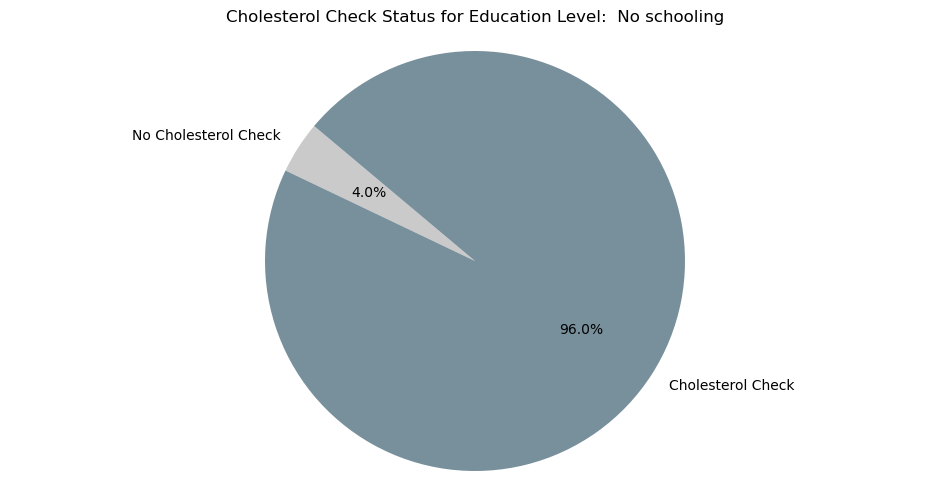

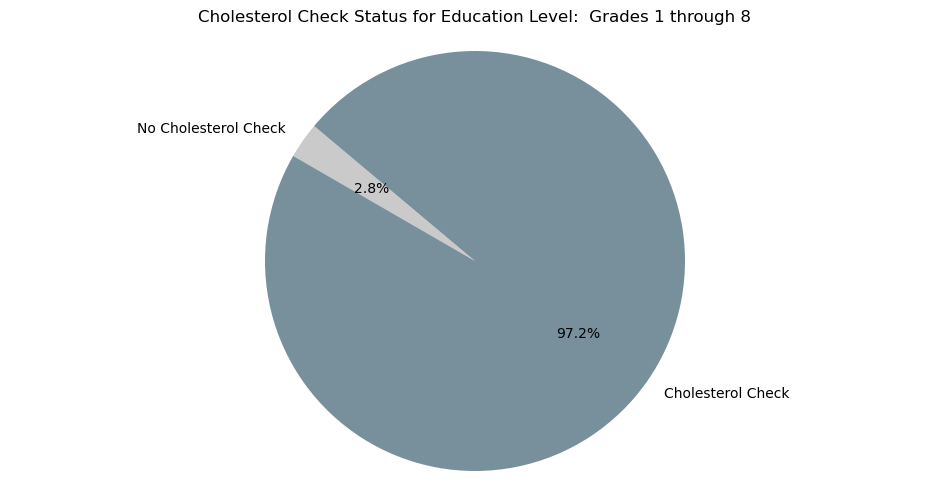

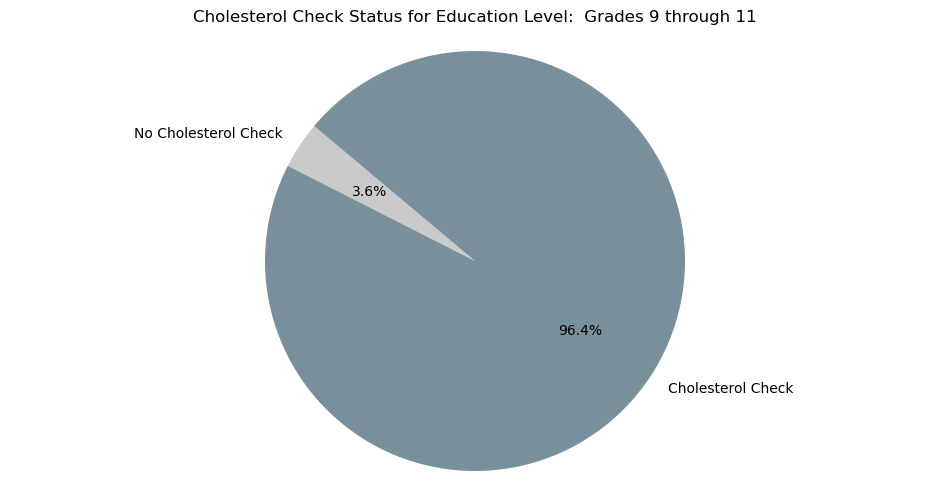

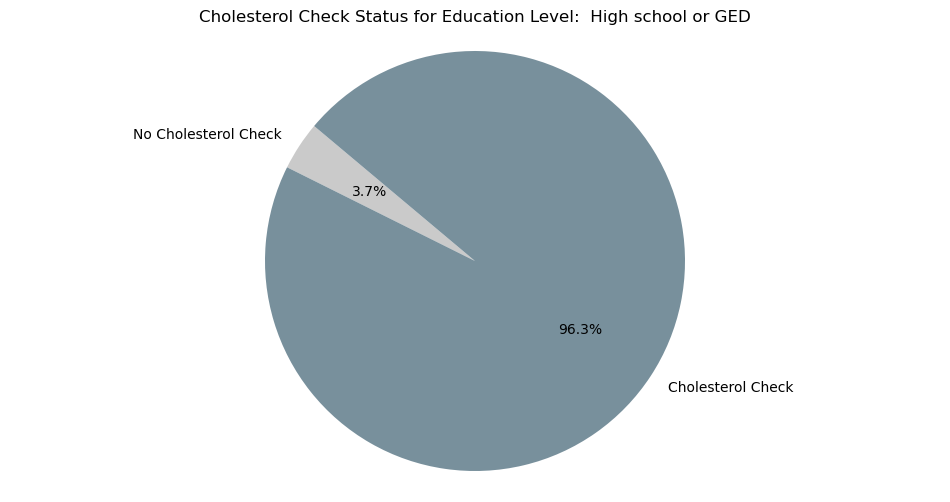

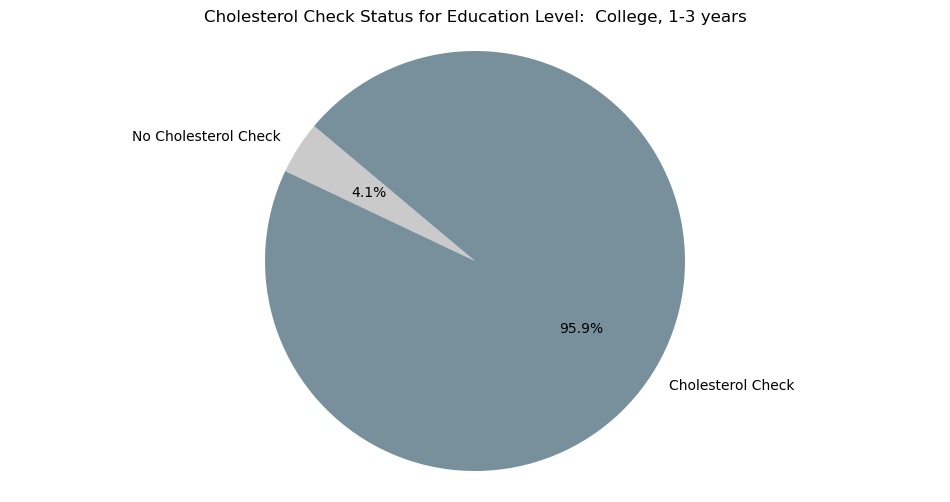

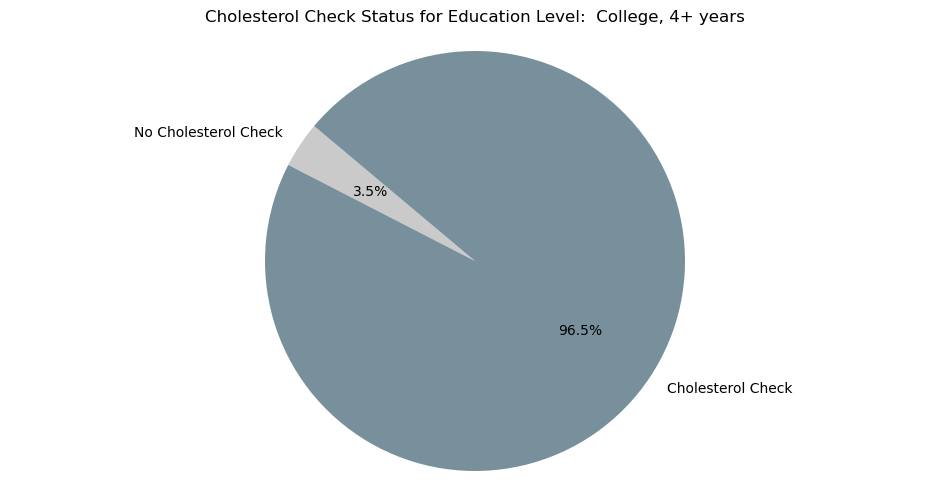

In [62]:
# Group by education and cholesterol check, count the number of responses in each row
edu_chol = df_trimmed.groupby(['Education', 'CholCheck']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
educhol_group_sum = edu_chol.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_chol['proportion'] = (edu_chol['count'] / educhol_group_sum) * 100

# Pivot the table
educhol_pivot_df = edu_chol.pivot(index='Education', columns='CholCheck', values='proportion')

# Rename columns for easy display formatting
educhol_pivot_df.columns = ['No Cholesterol Check', 'Cholesterol Check']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

educhol_pivot_df.index = educhol_pivot_df.index.map(index_mapping)


# Create a pie chart for each education level
i = 1
for education_level in index_mapping.values():

    # Filter the data for the current education level using the index
    level_data = educhol_pivot_df.loc[education_level]
    
    # Only create a pie chart if there is data
    if not level_data.empty:
        labels = ['No Cholesterol Check', 'Cholesterol Check']
        sizes = level_data.values  # Use values from the filtered data
        colors = ['#CACACA', '#78909C', '#616161']
        
        # Plot the pie chart
        plt.figure(figsize=(12, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f"Cholesterol Check Status for Education Level:  {education_level}")
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.savefig(f"Images/cholesterol_vs_education{i}.png")
        plt.show()
    
    i += 1
   

In [63]:
# # Create pie charts to visualize the average cholesterol check status by education level and diabetes status.


# # Define the education scale mapping
# education_scale = {
#     1: 'Never attended school or only kindergarten',
#     2: 'Grades 1 through 8 (Elementary)',
#     3: 'Grades 9 through 11 (Some high school)',
#     4: 'Grade 12 or GED (High school graduate)',
#     5: 'College 1 year to 3 years (Some college)',
#     6: 'College 4 years or more (College graduate)'
# }

# # Map the Education column to the descriptive categories
# diabetes_df['Education'] = diabetes_df['Education'].map(education_scale)

# # Drop rows with missing data in the relevant columns
# diabetes_df = diabetes_df.dropna(subset=['Education', 'CholCheck', 'Diabetes_012'])

# # Group the data by Education and CholCheck to count occurrences
# education_cholcheck = diabetes_df.groupby(['Education', 'CholCheck']).size().reset_index(name='count')

# # Create a pie chart for each education level
# i = 1
# for education_level in education_scale.values():

#     # Filter the data for the current education level
#     level_data = education_cholcheck[education_cholcheck['Education'] == education_level]
#     labels = ['No Cholesterol Check', 'Cholesterol Check']
#     sizes = level_data['count'].values if not level_data.empty else [0, 0]
#     # Filter the data for the current education level
#     level_data = education_cholcheck[education_cholcheck['Education'] == education_level]
    
#     # Only create a pie chart if there is data
#     if not level_data.empty:
#         labels = ['No Cholesterol Check', 'Cholesterol Check']
#         sizes = level_data['count'].values
#         colors = ['#CACACA','#78909C','#616161']
        
#         # Plot the pie chart
#         plt.figure(figsize=(12, 6))
#         plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
#         plt.title(f"Cholesterol Check Status for Education Level:  {education_level}")
#         plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#        # plt.savefig("images/cholesterol_vs_education.png")
#         plt.savefig(f"images/cholesterol_vs_education{i}.png")
#         plt.show()
#     i += 1
   

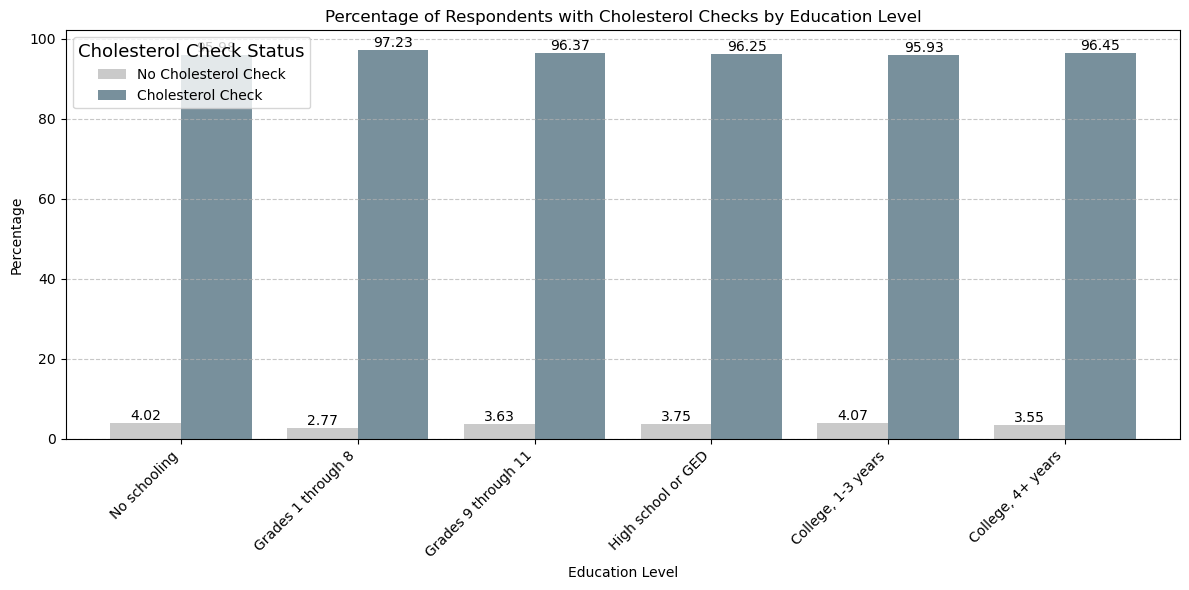

In [64]:
# Create a bar chart to visualize the average cholesterol check status by education level and diabetes status.


# Group by education and cholesterol check status, then count the occurrences
dia_edu = df_trimmed.groupby(["Education", "CholCheck"]).size().reset_index(name='count')

# Calculate the sum of responses for each education group
education_group_sum = dia_edu.groupby('Education')['count'].transform('sum')

# Calculate the proportions
dia_edu['proportion'] = (dia_edu['count'] / education_group_sum) * 100

# Pivot the table to prepare for plotting
edu_pivot_df = dia_edu.pivot(index='Education', columns='CholCheck', values='proportion')

# Rename columns for clarity
edu_pivot_df.columns = ['No Cholesterol Check', 'Cholesterol Check']

# Map the education levels for better display
index_mapping = {
    1: 'No schooling',
    2: 'Grades 1 through 8',
    3: 'Grades 9 through 11',
    4: 'High school or GED',
    5: 'College, 1-3 years',
    6: 'College, 4+ years',
}
edu_pivot_df.index = edu_pivot_df.index.map(index_mapping)

# Define colors for the bar chart
colors = ['#CACACA','#78909C']

# Plot the table as a bar chart
ax = edu_pivot_df.plot(kind='bar', width=0.8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Cholesterol Checks by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Cholesterol Check Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/cholesterol_vs_education.png")
plt.show()




In [65]:
# Education data shown with the Chi-Square Test
# Create a contingency table

from scipy.stats import chi2_contingency  # Import Chi-Square test function
contingency_table = pd.crosstab(diabetes_df['Education'], diabetes_df['CholCheck'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
colors = ['#CACACA','#78909C','#616161']
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)
# Interpretation
if p < 0.05:
    print("\nThere is a statistically significant association between education level and cholesterol check status (p < 0.05).")
else:
    print("\nThere is no statistically significant association between education level and cholesterol check status (p >= 0.05).")

# Create a summary DataFrame for the Chi-Square test results
chi_square_results = pd.DataFrame({
    'Chi-Square Statistic': [chi2],
    'P-Value': [p],
    'Degrees of Freedom': [dof]
})

Contingency Table:
CholCheck   0.0     1.0
Education              
1.0           7     167
2.0         112    3931
3.0         344    9134
4.0        2352   60398
5.0        2845   67065
6.0        3810  103515

Chi-Square Test Results:
Chi-Square Statistic: 42.82749480123138
P-Value: 4.00481765876846e-08
Degrees of Freedom: 5

Expected Frequencies:
[[6.49550615e+00 1.67504494e+02]
 [1.50927192e+02 3.89207281e+03]
 [3.53818433e+02 9.12418157e+03]
 [2.34248857e+03 6.04075114e+04]
 [2.60977491e+03 6.73002251e+04]
 [4.00649539e+03 1.03318505e+05]]

There is a statistically significant association between education level and cholesterol check status (p < 0.05).


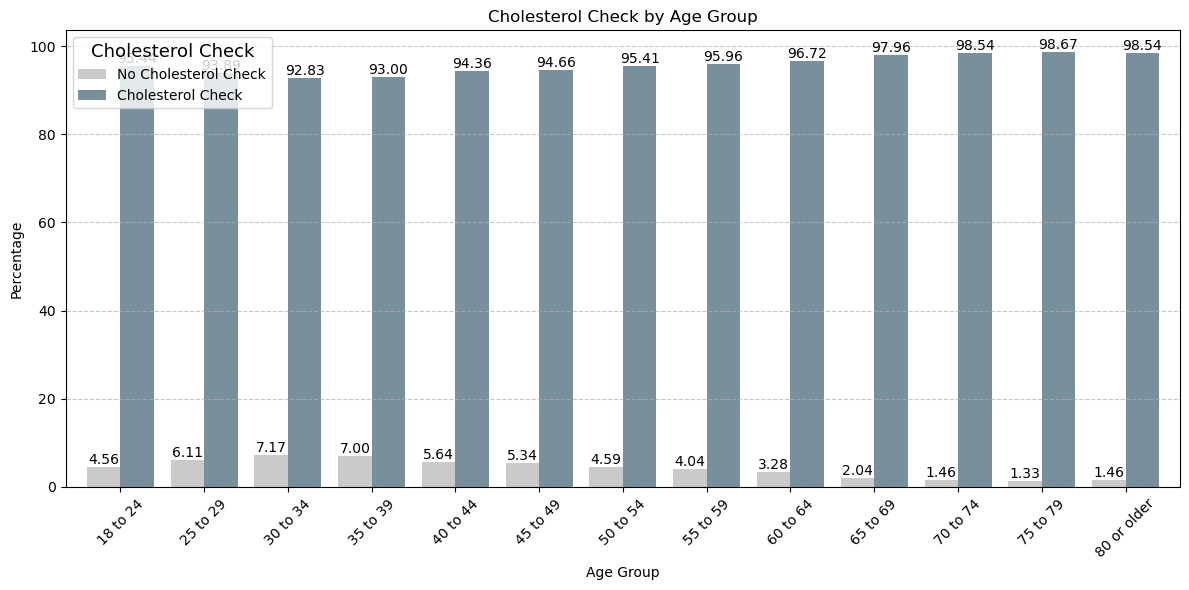

In [66]:
# Group by age and cholcheck, count the number of responses in each row
age_chol = df_trimmed.groupby(['Age', 'CholCheck']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
agechol_group_sum = age_chol.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_chol['proportion'] = (age_chol['count'] / agechol_group_sum) * 100

# Pivot the table
agechol_pivot_df = age_chol.pivot(index='Age', columns='CholCheck', values='proportion')

# Rename columns for easy display formatting
agechol_pivot_df.columns = ['No Cholesterol Check', 'Cholesterol Check']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

agechol_pivot_df.index = agechol_pivot_df.index.map(index_mapping)

# Plot the table
ax = agechol_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=colors)
plt.title('Cholesterol Check by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(agechol_pivot_df.index)), labels=agechol_pivot_df.index, rotation=45)
plt.legend(title='Cholesterol Check', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/cholesterol_vs_age.png")
plt.show()

In [67]:
# # Cholesterol checks by age


# # Map the 13-level age categories (_AGEG5YR) to their corresponding age ranges
# age_map = {
#     1: 18, 2: 25, 3: 30, 4: 35, 5: 40, 6: 45,
#     7: 50, 8: 55, 9: 60, 10: 65, 11: 70, 12: 75, 13: 80
# }

# # Apply the mapping to create a new 'Mapped_Age' column
# diabetes_df['Mapped_Age'] = diabetes_df['Age'].map(age_map)


# # Define the new age cohorts using bins and labels
# age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
# age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']




# # Create a new column in the DataFrame for age cohorts
# diabetes_df['Age_Cohort'] = pd.cut(diabetes_df['Mapped_Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# # Drop rows with missing data in the relevant columns
# diabetes_df = diabetes_df.dropna(subset=['Age_Cohort', 'CholCheck'])

# # Group by age cohort and cholesterol check status, and count the number of participants for each category
# dia_age_chol = diabetes_df.groupby(["Age_Cohort", "CholCheck"], observed=True).size().reset_index(name='count')

# # Plot the data as a bar chart
# fig, ax = plt.subplots(figsize=(10, 6))

# # Separate data into groups based on cholesterol check status
# nocholcheck = dia_age_chol[dia_age_chol["CholCheck"] == 0].copy()
# yescholcheck = dia_age_chol[dia_age_chol["CholCheck"] == 1].copy()

# # Plotting the no cholesterol check group
# ax.bar(nocholcheck["Age_Cohort"], nocholcheck["count"], width=0.4, label="No Cholesterol Check", align='center', color = ['#78909C'])
# colors = ['#78909C','#616161', '#CACACA']

# # Plotting the cholesterol check group, shifted slightly to the right
# ax.bar(yescholcheck["Age_Cohort"], yescholcheck["count"], width=0.4, label="Cholesterol Check", align='edge', color= [ '#CACACA'])
# colors = ['#78909C','#616161', '#CACACA']
# # Set the labels and title
# colors = ['#78909C','#616161', '#CACACA']
# ax.set_xlabel("Age Cohort")
# ax.set_ylabel("Number of Respondents")
# ax.set_title("Number of Respondents by Cholesterol Check Status and Age Cohort")
# ax.legend()
# plt.savefig("images/cholesterol_vs_age.png")

# # Display the plot
# plt.tight_layout()
# plt.show()




In [68]:
# # Cholesterol by age shown in a pivot table 

# pivot_table = diabetes_df.pivot_table(
#     values='Mapped_Age', 
#     index='Age_Cohort', 
#     columns='CholCheck', 
#     aggfunc='count', 
#     fill_value=0, 
#     observed=True  # Set observed=True to silence the warning and use future behavior
# )

# # Plot the pivot table as a bar chart 
# colors = ['#CACACA','#78909C','#616161']
# pivot_table.plot(kind='bar', figsize=(10, 6), color=colors)


# # Set the labels and title
# plt.xlabel("Age Cohort")
# plt.ylabel("Number of Respondents")
# plt.title("Number of Respondents by Cholesterol Check Status and Age Cohort")
# plt.legend(["No Cholesterol Check", "Cholesterol Check"])
# plt.savefig("images/cholesterol_vs_age.png")

# # Display the plot
# plt.tight_layout()
# plt.show()


In [69]:
# # Cholesterol by age chi- squared test


# # Map the 13-level age categories (_AGEG5YR) to their corresponding age ranges
# age_map = {
#     1: 18, 2: 25, 3: 30, 4: 35, 5: 40, 6: 45,
#     7: 50, 8: 55, 9: 60, 10: 65, 11: 70, 12: 75, 13: 80
# }

# # Apply the mapping to create a new 'Mapped_Age' column
# diabetes_df['Mapped_Age'] = diabetes_df['Age'].map(age_map)

# # Define the new age cohorts using bins and labels
# age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
# age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

# # Create a new column in the DataFrame for age cohorts
# diabetes_df['Age_Cohort'] = pd.cut(diabetes_df['Mapped_Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# # Drop rows with missing data in the relevant columns
# diabetes_df = diabetes_df.dropna(subset=['Age_Cohort', 'CholCheck'])

# # Create a contingency table between Age_Cohort and CholCheck
# contingency_table = pd.crosstab(diabetes_df['Age_Cohort'], diabetes_df['CholCheck'])

# # Perform the Chi-Square test
# chi2, p, dof, expected = chi2_contingency(contingency_table)

# # Display the results
# print("Contingency Table:")
# print(contingency_table)
# print("\nChi-Square Test Results:")
# print(f"Chi-Square Statistic: {chi2}")
# print(f"P-Value: {p}")
# print(f"Degrees of Freedom: {dof}")
# print("\nExpected Frequencies:")
# print(expected)

# # Interpretation
# if p < 0.05:
#     print("\nThere is a statistically significant association between age cohort and cholesterol check status (p < 0.05).")
# else:
#     print("\nThere is no statistically significant association between age cohort and cholesterol check status (p >= 0.05).")

In [70]:
# Run the Chi-squared test for all age categories
chi2, p, dof, expected = stats.chi2_contingency(agechol_pivot_df)

# Output the results
print(f"For all age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

# Filter the dataframe to only the highest and lowest age categories (the greatest difference in proportions)
agechol_highlow = agechol_pivot_df.loc[["18 to 24", "80 or older"]]

# Run the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(agechol_highlow)

# Output the results
print(f"For highest and lowest age categories:")
print(f"Chi-squared statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)
if p > 0.05:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.")
else:
    print(f"The p-value of the chi-squared test is {round(p, 4)}. As this value is less than 0.05, we reject the null hypothesis. The samples are therefore statistically different.")

For all age categories:
Chi-squared statistic: 13.222986046899852
p-value: 0.3530436604774034
Degrees of freedom: 12
Expected frequencies:
[[ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]
 [ 4.15567121 95.84432879]]
The p-value of the chi-squared test is 0.353. As this value is greater than 0.05, we fail to reject the null hypothesis. The samples are therefore not statistically different.
For highest and lowest age categories:
Chi-squared statistic: 0.7537103877736544
p-value: 0.3853040366433065
Degrees of freedom: 1
Expected frequencies:
[[ 3.01214217 96.98785783]
 [ 3.01214217 96.98785783]]
The p-value of the chi-squared test is 0.3853. As this value is greater than 0.05, we fail to reject the null hypothesis. The

### Summary:

The analysis of cholesterol checks across different demographic indicators—age, education, and income—reveals clear patterns of health behavior and access to preventive care. Older adults, those with higher educational attainment, and individuals with higher incomes are more likely to have undergone cholesterol checks. These findings underscore the critical role of socioeconomic factors in healthcare access and the importance of targeted public health interventions to increase preventive care among younger, less educated, and lower-income populations.

## Muad - Body Mass Index (BMI)

In [73]:
# # Import necessary libraries
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# import statsmodels.stats.multicomp as mc

In [74]:
# # Trim the dataframe so it is only our variables of interest
# df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()


In [75]:
# Map the education codes to their corresponding labels and set the order
education_labels = {
    1: 'Never attended/KG',
    2: 'Grade 1-8',
    3: 'Grade 9-11',
    4: '12-GED',
    5: 'College 1-3',
    6: 'College Graduate'
}

education_order = ['Never attended/KG', 'Grade 1-8', 'Grade 9-11', '12-GED', 'College 1-3', 'College Graduate']

df_trimmed['Education'] = pd.Categorical(df_trimmed['Education'].map(education_labels), categories=education_order, ordered=True)


In [76]:
# Print the distribution of categories in the data
print("Income Distribution:")
print(diabetes_df['Income'].value_counts())
print("\nEducation Distribution:")
print(diabetes_df['Education'].value_counts())
print("\nAge Distribution:")
print(diabetes_df['Age'].value_counts())


Income Distribution:
Income
8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: count, dtype: int64

Education Distribution:
Education
6.0    107325
5.0     69910
4.0     62750
3.0      9478
2.0      4043
1.0       174
Name: count, dtype: int64

Age Distribution:
Age
9.0     33244
10.0    32194
8.0     30832
7.0     26314
11.0    23533
6.0     19819
13.0    17363
5.0     16157
12.0    15980
4.0     13823
3.0     11123
2.0      7598
1.0      5700
Name: count, dtype: int64


In [77]:
# Map the age codes to their corresponding labels and set the order
age_labels = {
    1: '18-24',
    2: '25-29',
    3: '30-34',
    4: '35-39',
    5: '40-44',
    6: '45-49',
    7: '50-54',
    8: '55-59',
    9: '60-64',
    10: '65-69',
    11: '70-74',
    12: '75-79',
    13: '80+'
}

age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

df_trimmed['Age'] = pd.Categorical(df_trimmed['Age'].map(age_labels), categories=age_order, ordered=True)


In [78]:
# Map the income codes to their corresponding labels and set the order
income_labels = {
    1: 'Less than $10,000',
    2: '$10,000 to <$15,000',
    3: '$15,000 to <$20,000',
    4: '$20,000 to <$25,000',
    5: '$25,000 to <$35,000',
    6: '$35,000 to <$50,000',
    7: '$50,000 to <$75,000',
    8: '$75,000 or more'
}

income_order = ['Less than $10,000', '$10,000 to <$15,000', '$15,000 to <$20,000', '$20,000 to <$25,000', '$25,000 to <$35,000', '$35,000 to <$50,000', '$50,000 to <$75,000', '$75,000 or more']

df_trimmed['Income'] = pd.Categorical(df_trimmed['Income'].map(income_labels), categories=income_order, ordered=True)


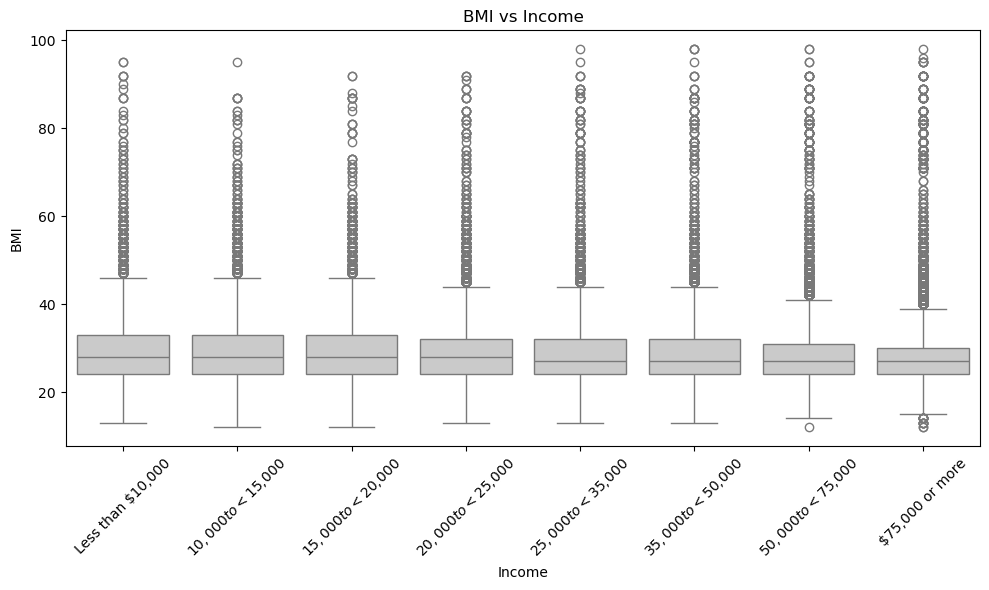

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Income', y='BMI', data=diabetes_df, hue='Income', palette=['#CACACA'])
plt.title('BMI vs Income')
plt.xlabel('Income')
plt.ylabel('BMI')
plt.xticks(ticks = range(len(income_order)), labels = income_order, rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('Images/BMI_vs_Income.png')  # Save as PNG file
plt.show()


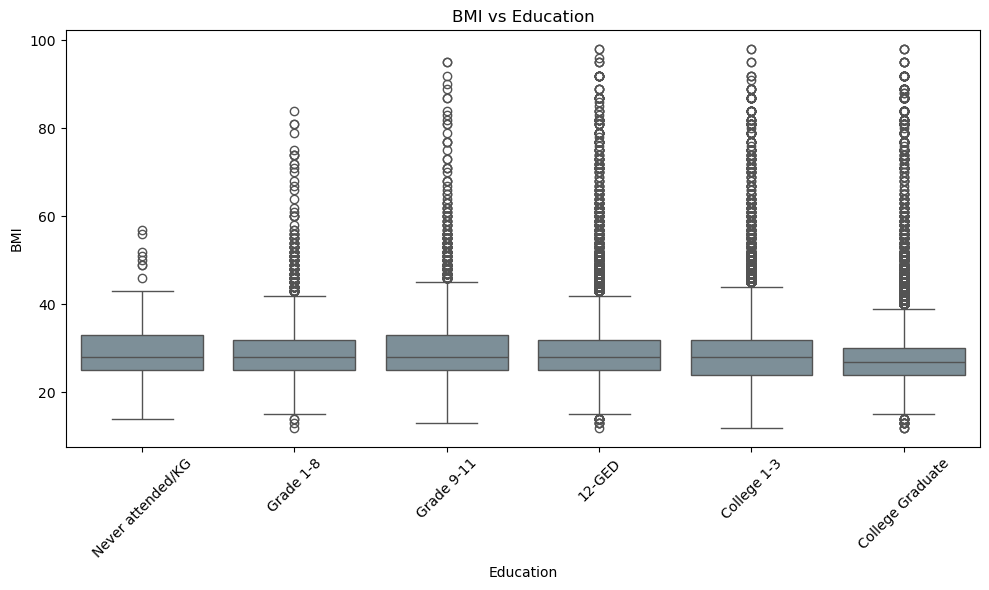

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='BMI', data=diabetes_df, hue='Education', palette=['#78909C'])
plt.title('BMI vs Education')
plt.xlabel('Education')
plt.ylabel('BMI')
plt.xticks(ticks = range(len(education_order)), labels = education_order, rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('Images/BMI_vs_Education.png')  # Save as PNG file
plt.show()


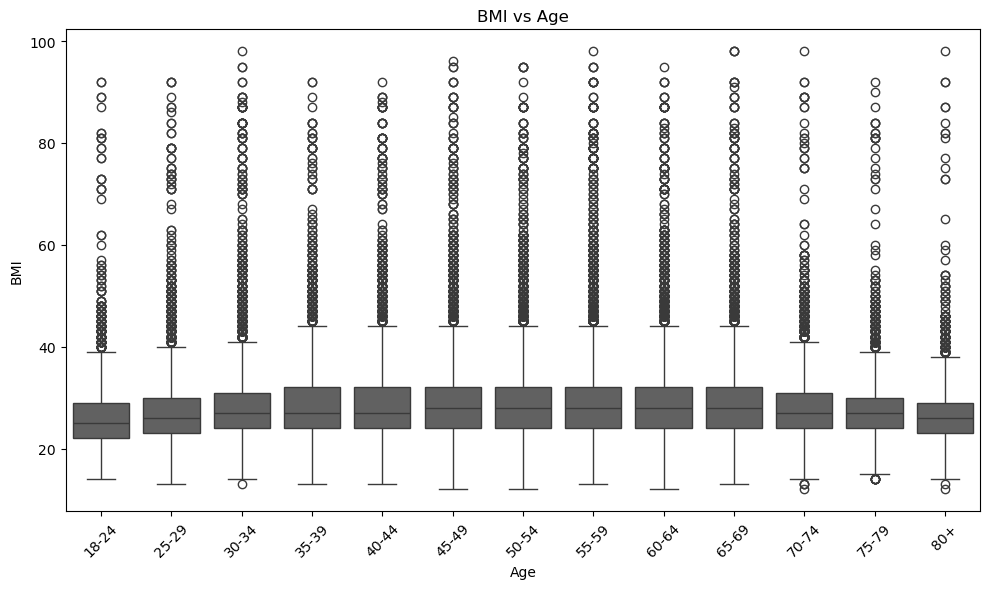

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='BMI', data=diabetes_df, hue='Age', palette=['#616161'])
plt.title('BMI vs Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.xticks(ticks = range(len(age_order)), labels = age_order, rotation=45)
plt.legend([], [], frameon=False)  # Hide the legend
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig('Images/BMI_vs_Age.png')  # Save as PNG file
plt.show()


ANOVA Table:
                       sum_sq        df            F  PR(>F)
C(Diabetes_012)  5.612684e+05       2.0  6768.361067     0.0
Residual         1.051812e+07  253677.0          NaN     NaN
Tukey's HSD Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   0.0    1.0   2.9819   0.0 2.7578 3.2061   True
   0.0    2.0   4.2015   0.0 4.1148 4.2881   True
   1.0    2.0   1.2195   0.0 0.9837 1.4554   True
-------------------------------------------------


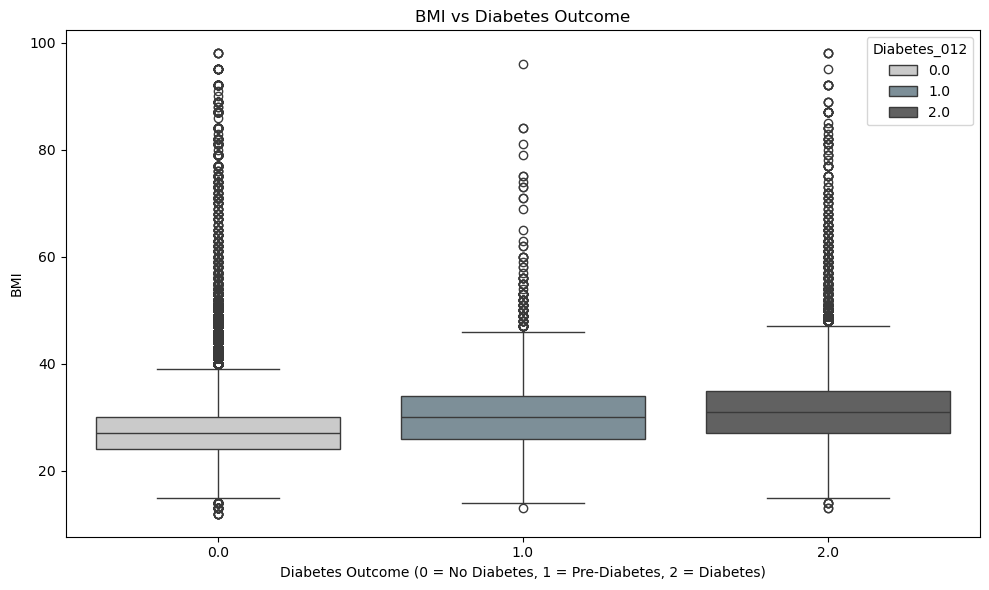

In [82]:
# Load the relevant dataset
data = diabetes_df

# Perform ANOVA
anova_model = ols('BMI ~ C(Diabetes_012)', data=data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("ANOVA Table:")
print(anova_table)

# Check if ANOVA is significant (p < 0.05), then perform Tukey's HSD
if anova_table['PR(>F)'][0] < 0.05:
    tukey = mc.pairwise_tukeyhsd(data['BMI'], data['Diabetes_012'], alpha=0.05)
    print("Tukey's HSD Test:")
    print(tukey)

# Visualization of BMI vs Diabetes Outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='Diabetes_012', y='BMI', data=data, hue='Diabetes_012', palette=['#CACACA','#78909C','#616161'])
plt.title('BMI vs Diabetes Outcome')
plt.xlabel('Diabetes Outcome (0 = No Diabetes, 1 = Pre-Diabetes, 2 = Diabetes)')
plt.ylabel('BMI')
plt.tight_layout()
plt.savefig('Images/BMI_vs_Diabetes_Outcome.png')
plt.show()

### Summary:
The analysis shows that income and education have minimal impact on BMI, but age has a clear link, with BMI increasing as individuals age. Additionally, the strong correlation between BMI and diabetes highlights the need for targeted interventions to address both.


## Sophia - Heavy Alcohol Consumption

In [85]:
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [86]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


In [87]:
# Group by heavy alcohol consumption and diabetes status, count the number of participants for each category
alcohol_vs_diabetes = df_trimmed.groupby(["HvyAlcoholConsump", "Diabetes_012"]).size().reset_index(name='count')
alcohol_vs_diabetes
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
no_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 0].copy()
yes_alc = alcohol_vs_diabetes[alcohol_vs_diabetes["HvyAlcoholConsump"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
no_alc_sum = no_alc["count"].sum()
no_alc["proportion"] = (no_alc["count"] / no_alc_sum) * 100

yes_alc_sum = yes_alc["count"].sum()
yes_alc["proportion"] = (yes_alc["count"] / yes_alc_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
alcoholstack = pd.concat([no_alc, yes_alc], ignore_index=False)
alcoholstack



,HvyAlcoholConsump,Diabetes_012,count,proportion
0,0.0,0.0,200487,83.737219
1,0.0,1.0,4423,1.847350
2,0.0,2.0,34514,14.415430
3,1.0,0.0,13216,92.704826
4,1.0,1.0,208,1.459035
5,1.0,2.0,832,5.836139


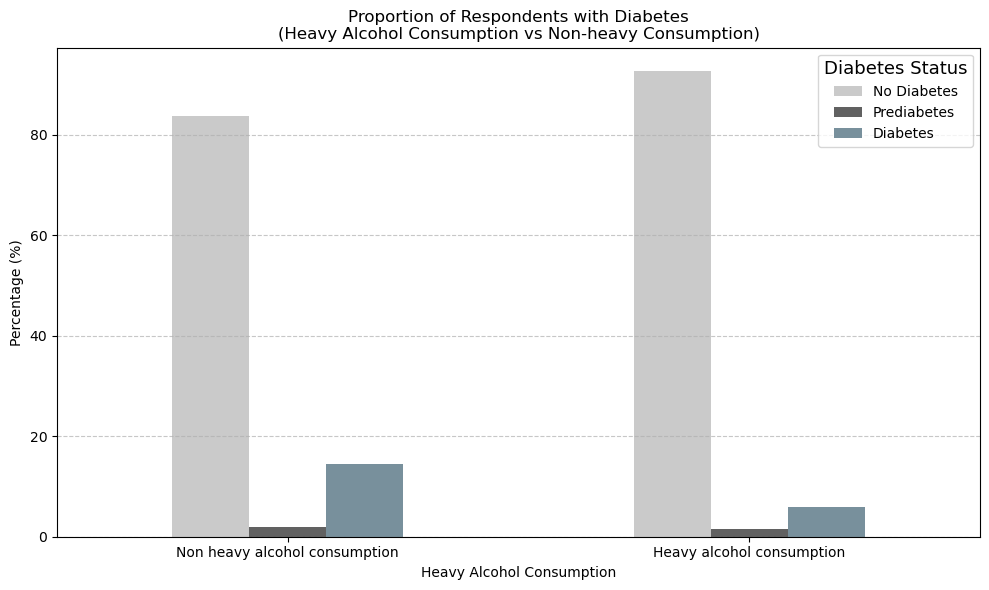

In [88]:
# Set up pivot table to reorganize fruitstack df
alc_pivot_df =alcoholstack.pivot(index='HvyAlcoholConsump', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
alc_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']


# Rename indices for easy display formatting
index_mapping = {0.0: 'Non heavy alcohol consumption', 1.0: 'Heavy alcohol consumption'}
alc_pivot_df.index = alc_pivot_df.index.map(index_mapping)

# Plot the table
alc_pivot_df.plot(kind='bar', figsize=(10, 6), color = ['#cacaca', '#616161', '#78909c'])
plt.title('Proportion of Respondents with Diabetes\n(Heavy Alcohol Consumption vs Non-heavy Consumption)')
plt.xlabel('Heavy Alcohol Consumption')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=range(len(alc_pivot_df.index)), labels=alc_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("Images/diabetes_vs_alc.png")
plt.show()



In [89]:
# Running chi squared test
chi2, p, dof, expected = stats.chi2_contingency(alc_pivot_df)

print(f"Chi-squared statistics: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies")
print(expected)
if p>.05:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is greater than .05 so it is a null hypothesis\
 and not statistically significant")
else:
    print(f"The p-value of the chi-squared test is {round(p,4)}. This value is less than .05, making it an alternative hypthesis\
    and statistically significant")

Chi-squared statistics: 4.1358763815397435
p-value: 0.1264462211103922
Degrees of freedom: 2
Expected frequencies
[[88.22102268  1.65319255 10.12578477]
 [88.22102268  1.65319255 10.12578477]]
The p-value of the chi-squared test is 0.1264. This value is greater than .05 so it is a null hypothesis and not statistically significant


In [90]:
# # Group by heavy alcohol consumption and income status, count the number of participants for each category
# alcohol_vs_diabetes_income = df_trimmed.groupby(["HvyAlcoholConsump", "Income"]).size().reset_index(name='count')
# alcohol_vs_diabetes_income
# # Separate 0 heavy alcohol consumption values from 1 heavy alcohol consumption values, copying the tables so we can easily perform actions on them
# no_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 0].copy()
# yes_alc_income = alcohol_vs_diabetes_income[alcohol_vs_diabetes_income["HvyAlcoholConsump"] == 1].copy()

# # Find the total respondents per category (heavy alcohol consumption vs non heavy alcohol consumption)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_alc_sum_income = no_alc_income["count"].sum()
# no_alc_income["proportion"] = (no_alc_income["count"] / no_alc_sum_income) * 100

# yes_alc_sum_income = yes_alc_income["count"].sum()
# yes_alc_income["proportion"] = (yes_alc_income["count"] / yes_alc_sum_income) * 100

# # Using the pd.concat() function, combine the two tables into the new df, which shows the proportions
# alcoholstack_income = pd.concat([no_alc_income, yes_alc_income], ignore_index=False)
# alcoholstack_income



In [91]:
# alcoholstack_income = alcoholstack_income.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# # Rename columns for clarity
# alcoholstack_income.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# alcoholstack_income.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# # Formatting
# plt.title('Proportion by Annual Income Level and Heavy Alcohol Consumption')
# plt.xlabel('Income Level')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['Less than $10k', 'Less than $15k', 'Less than $20k', 'Less than $25k', 'Less than $35k', 'Less than $50k', 'Less than $75k', 'More than $75k'], rotation=45)
# plt.legend(title='Heavy Alcohol Consumption Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [92]:
# #Heavy Alcohol Consumption and Age

# alcohol_vs_diabetes_age = df_trimmed.groupby(["HvyAlcoholConsump", "Age"]).size().reset_index(name='count')
# alcohol_vs_diabetes_age

# # Separate 0 Heavy Alcohol Consumption values from 1 Heavy Alcohol Consumption values
# no_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 0].copy()
# yes_alc_age = alcohol_vs_diabetes_age[alcohol_vs_diabetes_age["HvyAlcoholConsump"] == 1].copy()

# # Find the total respondents per category (Heavy Alcohol Consumption and no Heavy Alcohol Consumption)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_alc_sum_age = no_alc_age["count"].sum()
# no_alc_age["proportion"] = (no_alc_age["count"] / no_alc_sum_age) * 100

# yes_alc_sum_age = yes_alc_age["count"].sum()
# yes_alc_age["proportion"] = (yes_alc_age["count"] / yes_alc_sum_age) * 100

# # Using the pd.concat() function, combine the two tables into the new Heavy Alcohol Consumption df
# alcoholstack_age = pd.concat([no_alc_age, yes_alc_age], ignore_index=False)
# alcoholstack_age

In [93]:
# alcoholstack_age = alcoholstack_age.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# # Rename columns for clarity
# alcoholstack_age.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# alcoholstack_age.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# # Formatting
# plt.title('Proportion by Age and Heavy Alcohol Consumption')
# plt.xlabel('Age')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+' ], rotation=45)
# plt.legend(title='Heavy Alcohol Consumption Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

In [94]:
# #Heavy Alcohol Consumption to Education
# alcohol_vs_diabetes_edu = df_trimmed.groupby(["HvyAlcoholConsump", "Education"]).size().reset_index(name='count')


# # Separate 0 PhysActivity values from 1 PhysActivity values, copying the tables so we can easily perform actions on them
# no_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 0].copy()
# yes_alc_edu = alcohol_vs_diabetes_edu[alcohol_vs_diabetes_edu["HvyAlcoholConsump"] == 1].copy()

# # Find the total respondents per category (PhysActivity and no PhysActivity)
# # Create a new column for the proportion of respondents in each row out of their respective category
# no_alc_edu_sum = no_alc_edu["count"].sum()
# no_alc_edu["proportion"] = (no_alc_edu["count"] / no_alc_edu_sum) * 100

# yes_alc_edu_sum = yes_alc_edu["count"].sum()
# yes_alc_edu["proportion"] = (yes_alc_edu["count"] / yes_alc_edu_sum) * 100

# # Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
# alcoholstack_edu = pd.concat([no_alc_edu, yes_alc_edu], ignore_index=False)
# alcoholstack_edu

In [95]:
# alcoholstack_edu = alcoholstack_edu.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# # Rename columns for clarity
# alcoholstack_edu.columns = ['Heavy Alcohol Consumption', 'Non Heavy Alcohol Consumption']

# # Plot the bar graph
# fig, ax = plt.subplots(figsize=(10, 6))
# alcoholstack_edu.plot(kind='bar', ax=ax, color=['#78909c', '#616161'])

# # Formatting
# plt.title('Proportion by Education and Heavy Alcohol Consumption')
# plt.xlabel('Education')
# plt.ylabel('Proportion (%)')
# plt.xticks(rotation=0)  # Rotate x labels to horizontal
# ax.set_xticklabels(['No School', 'Elementary', 'Some High School', 'High School Graduate', 'Some College or Technical School', 'College Graduate'], rotation=45)
# plt.legend(title='Heavy Alcohol Consumption Status')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.tight_layout()
# plt.show()

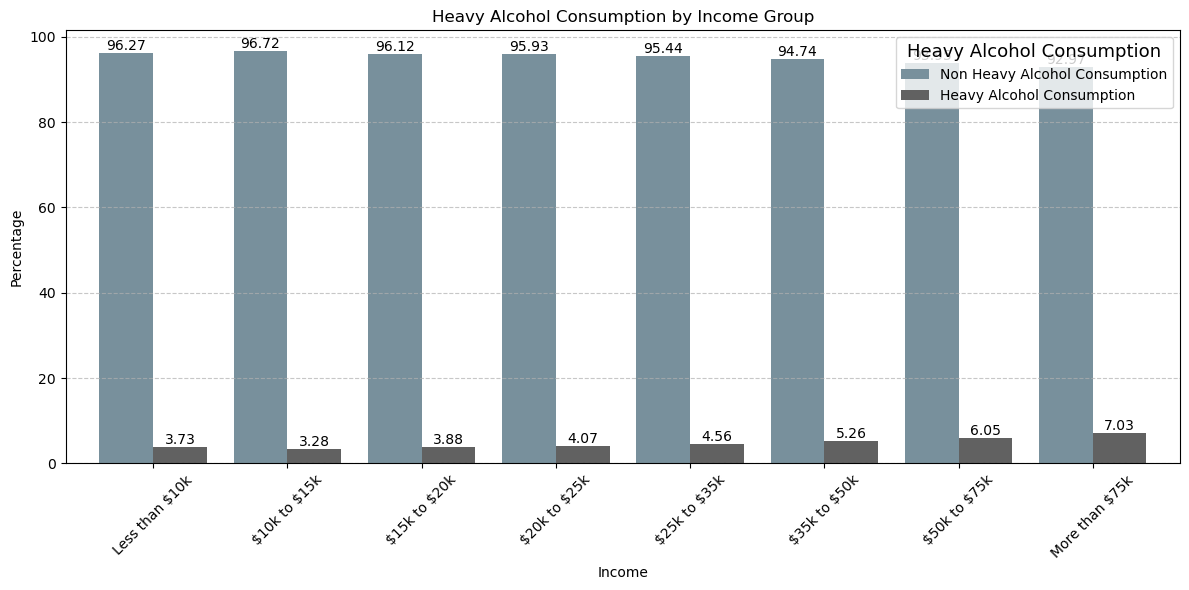

In [96]:
# Group by income and Heavy Alcohol Consumption, count the number of responses in each row
income_alc = df_trimmed.groupby(['Income', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each income group
income_alc_group_sum = income_alc.groupby('Income')['count'].transform('sum')

# Calculate the proportions
income_alc['proportion'] = (income_alc['count'] / income_alc_group_sum) * 100

# Pivot the table
income_alc_pivot_df = income_alc.pivot(index='Income', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
income_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'Less than \$10k',
                 2.0: '\$10k to \$15k',
                 3.0: '\$15k to \$20k',
                 4.0: '\$20k to \$25k',
                 5.0: '\$25k to \$35k',
                 6.0: '\$35k to \$50k',
                 7.0: '\$50k to \$75k',
                 8.0: 'More than \$75k'
                }

income_alc_pivot_df.index = income_alc_pivot_df.index.map(index_mapping)
income_alc_pivot_df
# Plot the table
ax = income_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'] )
plt.title('Heavy Alcohol Consumption by Income Group')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(income_alc_pivot_df.index)), labels=income_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/income_vs_alc.png")
plt.show()



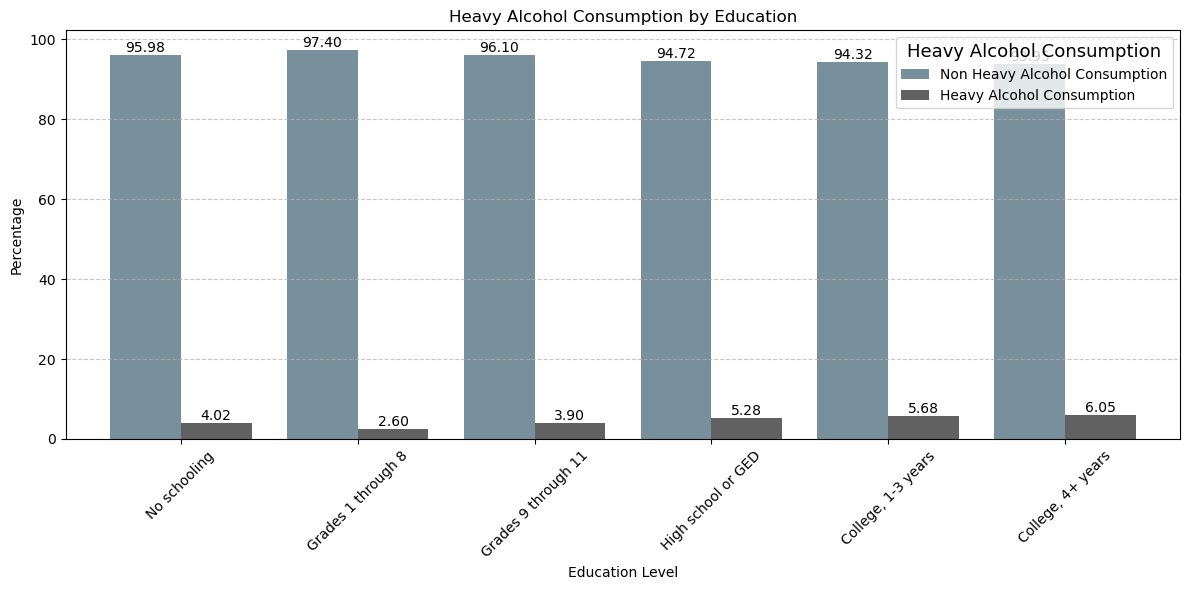

In [97]:
# Group by education and heavy alcohol consumption, count the number of responses in each row
edu_alc = df_trimmed.groupby(['Education', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each education group
edu_alc_group_sum = edu_alc.groupby('Education')['count'].transform('sum')

# Calculate the proportions
edu_alc['proportion'] = (edu_alc['count'] / edu_alc_group_sum) * 100

# Pivot the table
edu_alc_pivot_df = edu_alc.pivot(index='Education', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
edu_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: 'No schooling',
                 2.0: 'Grades 1 through 8',
                 3.0: 'Grades 9 through 11',
                 4.0: 'High school or GED',
                 5.0: 'College, 1-3 years',
                 6.0: 'College, 4+ years',
                }

edu_alc_pivot_df.index = edu_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = edu_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Education')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(edu_alc_pivot_df.index)), labels=edu_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/edu_vs_alc.png")
plt.show()

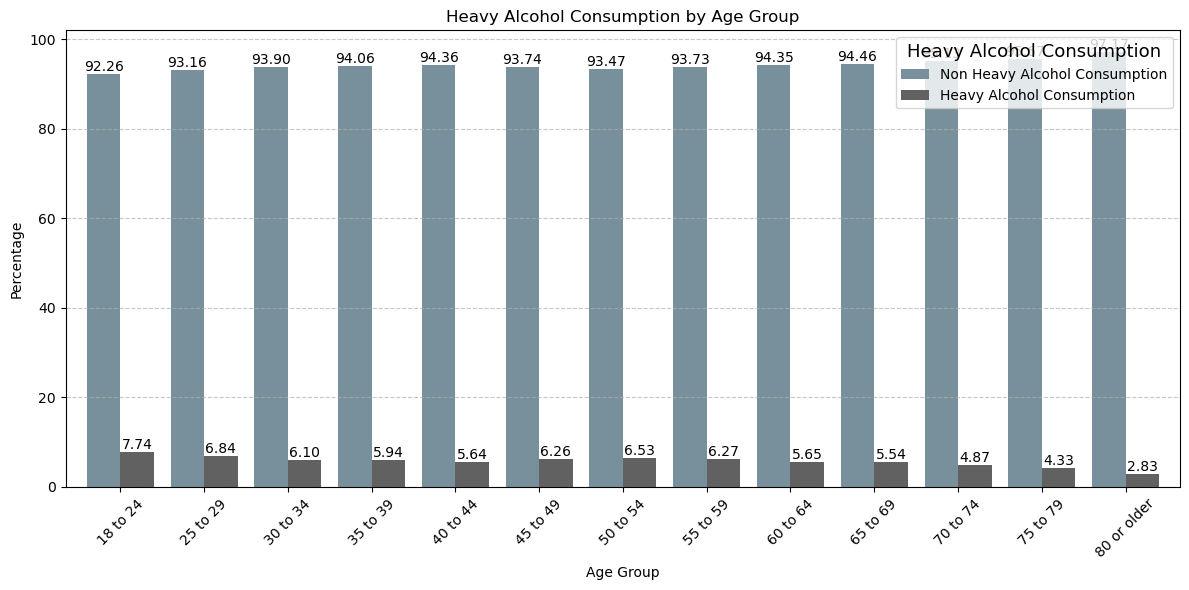

In [98]:
# Group by age and fruits, count the number of responses in each row
age_alc = df_trimmed.groupby(['Age', 'HvyAlcoholConsump']).size().reset_index(name='count')

# Calculate the sum of responses for each age group
age_alc_group_sum = age_alc.groupby('Age')['count'].transform('sum')

# Calculate the proportions
age_alc['proportion'] = (age_alc['count'] / age_alc_group_sum) * 100

# Pivot the table
age_alc_pivot_df = age_alc.pivot(index='Age', columns='HvyAlcoholConsump', values='proportion')

# Rename columns for easy display formatting
age_alc_pivot_df.columns = ['Non Heavy Alcohol Consumption', 'Heavy Alcohol Consumption']

# Rename indices for easy display formatting
index_mapping = {1.0: '18 to 24',
                 2.0: '25 to 29',
                 3.0: '30 to 34',
                 4.0: '35 to 39',
                 5.0: '40 to 44',
                 6.0: '45 to 49',
                 7.0: '50 to 54',
                 8.0: '55 to 59',
                 9.0: '60 to 64',
                 10.0: '65 to 69',
                 11.0: '70 to 74',
                 12.0: '75 to 79',
                 13.0: '80 or older'
                }

age_alc_pivot_df.index = age_alc_pivot_df.index.map(index_mapping)

# Plot the table
ax = age_alc_pivot_df.plot(kind='bar', width = .8, figsize=(12, 6), color=['#78909c', '#616161'])
plt.title('Heavy Alcohol Consumption by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(age_alc_pivot_df.index)), labels=age_alc_pivot_df.index, rotation=45)
plt.legend(title='Heavy Alcohol Consumption', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the percentages?
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge')
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.savefig("Images/age_vs_alc.png")
plt.show()


### Summary:
Across all income and education levels, a low percentage of respondents reported heavy alcohol consumption, though there is a slight increase in heavy drinking among higher income earners and more educated individuals. In contrast, heavy alcohol consumption declines with age, with the highest percentage found among the 18-24 age group. Interestingly, the data reveals that a higher proportion of individuals with diabetes are in the non-heavy alcohol consumption group.